In [1]:
!python -m pip install --upgrade pip

In [2]:
!pip install tqdm
!pip install mapie
!pip install graphviz
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install scipy
!pip install matplotlib
!pip install lightgbm
!pip install scikit-learn


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  # Importar tqdm

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Montar o Google Drive para acessar os arquivos
#drive.mount('/content/drive')

# Carregar dados do arquivo CSV
#file_path = '/content/drive/MyDrive/Mestrado/oficialtcld0903.csv'  # Substitua pelo caminho do seu arquivo
#file_path = '/content/drive/MyDrive/Mestrado/Bal75_50porcento.csv'  # Substitua pelo caminho do seu arquivo
#dt = pd.read_csv(file_path)

In [5]:
# Defina o caminho do arquivo
caminho_arquivo = 'C:/Users/franc/Downloads/oficialtcld0903.csv' # Altere este caminho conforme necessário

# Leia o arquivo
dt = pd.read_csv(caminho_arquivo)

# Visualize as primeiras linhas para verificar se a leitura foi bem-sucedida
print(dt.head())

   med10  sd10  med5  sd5  TCSacr     bal75
0   23.0   0.0  23.0  0.0    23.0  1684.598
1   23.0   0.0  23.0  0.0    23.0  1684.971
2   23.0   0.0  23.0  0.0    23.0  1685.343
3   23.0   0.0  23.0  0.0    23.0  1685.716
4   23.0   0.0  23.0  0.0    23.0  1686.088


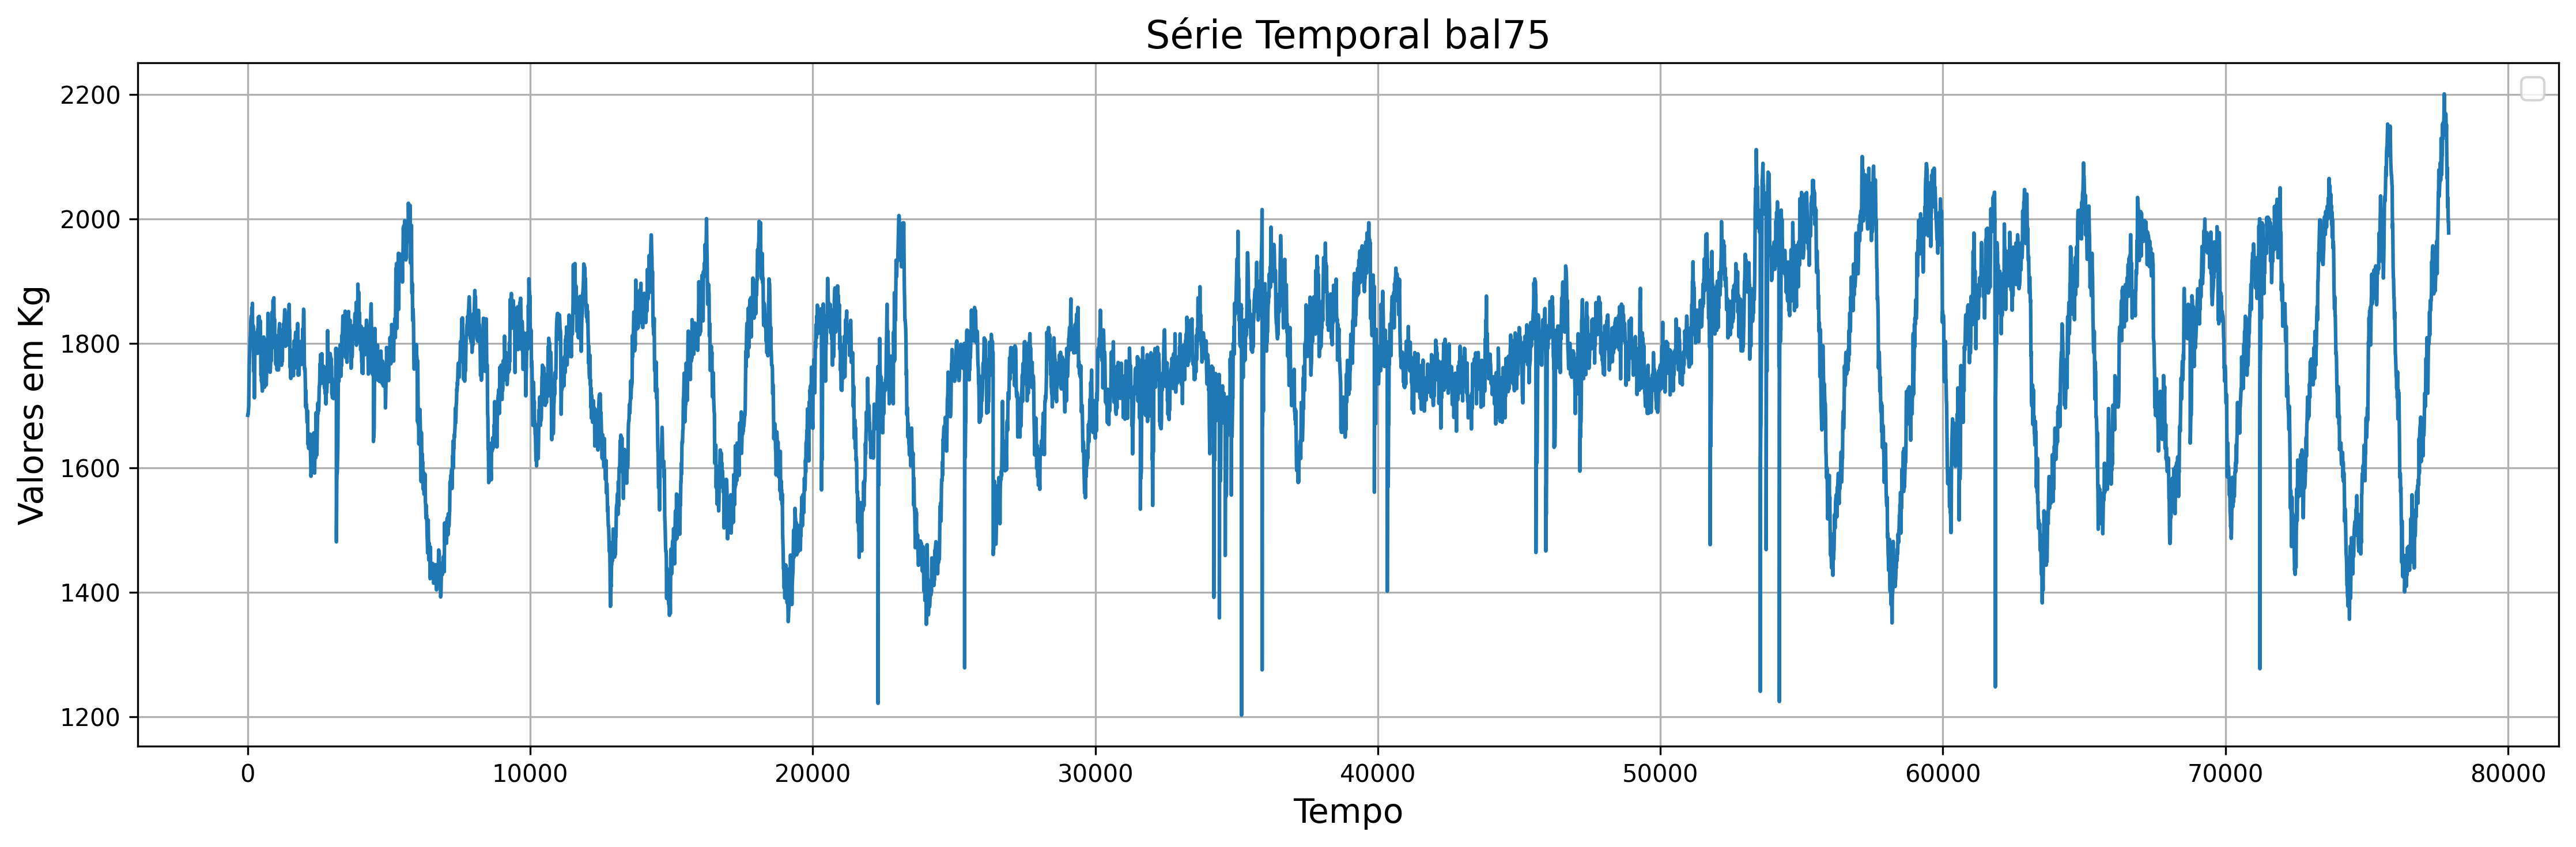

In [6]:
# Filtrar os índices onde os valores são menores que 1200
indices_menores_que_1200 = dt[dt['bal75'] < 1200].index

# Calcular a média da coluna 'bal75'
media_bal75 = dt['bal75'].mean()

# Substituir os valores menores que 1200 pela média
dt.loc[dt['bal75'] < 1200, 'bal75'] = media_bal75

# Verificar se os valores foram substituídos corretamente
#print(dt.loc[indices_menores_que_1200, 'bal75'])

# Plotar a Série Temporal que Desejamos Predizer
plt.figure(figsize=(15, 5),  dpi=300)
plt.plot(dt['bal75'])

# Adicionar títulos e legendas
plt.xlabel('Tempo', fontsize=14)
plt.ylabel('Valores em Kg', fontsize=14)
plt.title('Série Temporal bal75', fontsize=16)
plt.legend(fontsize=12)

# Melhorar a legibilidade do gráfico
plt.grid(True)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [8]:
'''
y_min = dt['bal75'].min()
y_max = dt['bal75'].max()

print(f"O valor mínimo de 'bal75' é: {y_min}")
print(f"O valor máximo de 'bal75' é: {y_max}")

'''

'\ny_min = dt[\'bal75\'].min()\ny_max = dt[\'bal75\'].max()\n\nprint(f"O valor mínimo de \'bal75\' é: {y_min}")\nprint(f"O valor máximo de \'bal75\' é: {y_max}")\n\n'

In [7]:
# Vamos criar algumas features a partir da coluna de interesse 'TCSacr'

# Features estatísticas em janelas de tempo
dt['mean_10s'] = dt['TCSacr'].rolling(window=10).mean()
dt['std_10s'] = dt['TCSacr'].rolling(window=10).std()
dt['min_10s'] = dt['TCSacr'].rolling(window=10).min()
dt['max_10s'] = dt['TCSacr'].rolling(window=10).max()

dt['mean_5s'] = dt['TCSacr'].rolling(window=5).mean()
dt['std_5s'] = dt['TCSacr'].rolling(window=5).std()
dt['min_5s'] = dt['TCSacr'].rolling(window=5).min()
dt['max_5s'] = dt['TCSacr'].rolling(window=5).max()

# Diferenças e Mudanças
dt['diff_1s'] = dt['TCSacr'].diff(periods=1)
dt['diff_5s'] = dt['TCSacr'].diff(periods=5)
dt['diff_10s'] = dt['TCSacr'].diff(periods=10)

# Lags
#data['lag_1s'] = data['TCSacr'].shift(1)
dt['lag_5s'] = dt['TCSacr'].shift(5)
dt['lag_10s'] = dt['TCSacr'].shift(10)
dt['lag_30s'] = dt['TCSacr'].shift(30)
dt['lag_60s'] = dt['TCSacr'].shift(60)

# Normalização
scaler = StandardScaler()
dt['TCSacr_scaled'] = scaler.fit_transform(dt[['TCSacr']])

dt = dt.drop(['med10', 'sd10', 'med5', 'sd5'], axis=1)
# Exibir o DataFrame com as novas features
print(dt.head())
dt = dt.dropna()
dt.head()

   TCSacr     bal75  mean_10s  std_10s  min_10s  max_10s  mean_5s  std_5s  \
0    23.0  1684.598       NaN      NaN      NaN      NaN      NaN     NaN   
1    23.0  1684.971       NaN      NaN      NaN      NaN      NaN     NaN   
2    23.0  1685.343       NaN      NaN      NaN      NaN      NaN     NaN   
3    23.0  1685.716       NaN      NaN      NaN      NaN      NaN     NaN   
4    23.0  1686.088       NaN      NaN      NaN      NaN     23.0     0.0   

   min_5s  max_5s  diff_1s  diff_5s  diff_10s  lag_5s  lag_10s  lag_30s  \
0     NaN     NaN      NaN      NaN       NaN     NaN      NaN      NaN   
1     NaN     NaN      0.0      NaN       NaN     NaN      NaN      NaN   
2     NaN     NaN      0.0      NaN       NaN     NaN      NaN      NaN   
3     NaN     NaN      0.0      NaN       NaN     NaN      NaN      NaN   
4    23.0    23.0      0.0      NaN       NaN     NaN      NaN      NaN   

   lag_60s  TCSacr_scaled  
0      NaN      -0.308572  
1      NaN      -0.308572  
2 

TCSacr     bal75   mean_10s   std_10s    min_10s    max_10s    mean_5s  \
60  22.485712  1773.381  22.935352  0.302523  22.485712  23.384993  22.685551   
61  22.385792  1774.599  22.835432  0.302523  22.385792  23.285072  22.585632   
62  22.285872  1775.818  22.735512  0.302523  22.285872  23.185152  22.485712   
63  22.185951  1777.037  22.635592  0.302523  22.185951  23.085232  22.385792   
64  22.086031  1778.256  22.535671  0.302523  22.086031  22.985312  22.285872   

      std_5s     min_5s     max_5s   diff_1s   diff_5s  diff_10s     lag_5s  \
60  0.157987  22.485712  22.885391 -0.099920 -0.499600 -0.999201  22.985312   
61  0.157987  22.385792  22.785471 -0.099920 -0.499599 -0.999201  22.885391   
62  0.157987  22.285872  22.685551 -0.099920 -0.499599 -0.999200  22.785471   
63  0.157988  22.185951  22.585632 -0.099921 -0.499600 -0.999201  22.685551   
64  0.157988  22.086031  22.485712 -0.099920 -0.499601 -0.999201  22.585632   

      lag_10s    lag_30s  lag_60s  TCSacr_scaled  
60  23.484913  23.517487     23.0      -0.764833  
61  23.384993  23.617407     23.0      -0.853480  
62  23.285072  23.717325     23.0      -0.942126  
63  23.185152  23.817245     23.0      -1.030773  
64  23.085232  23.917166     23.0      -1.119419

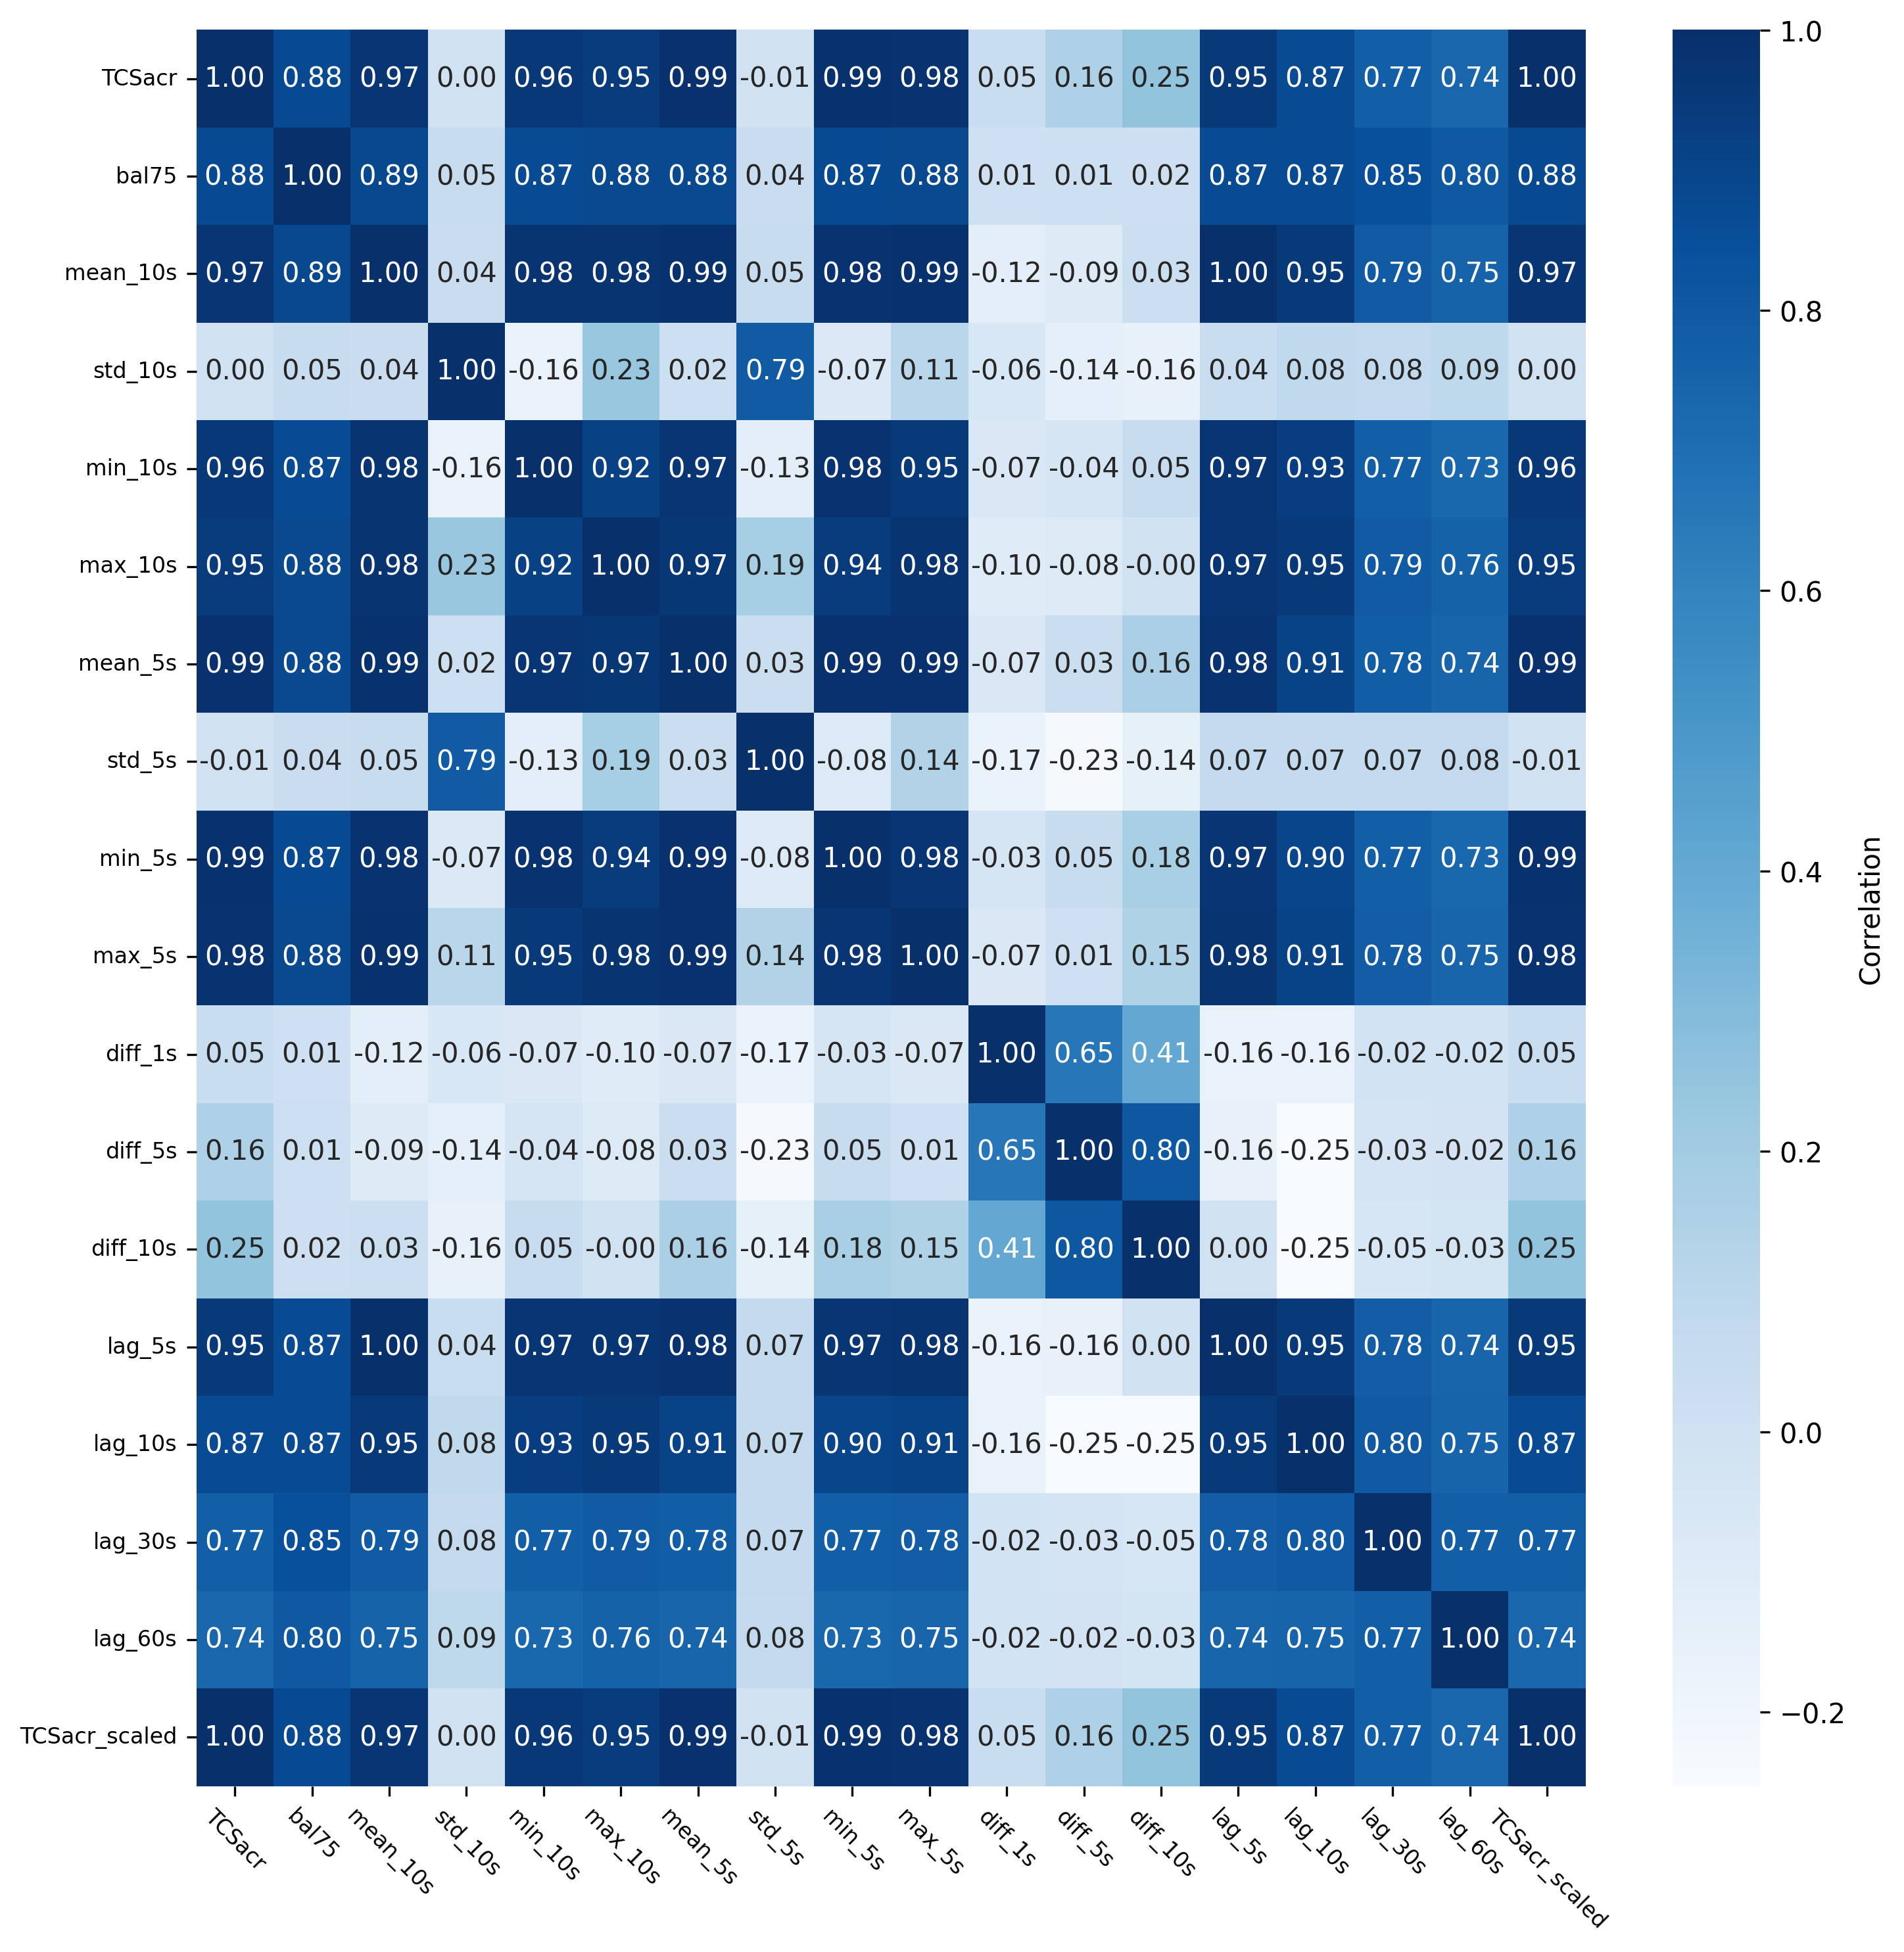

In [8]:
# Supondo que 'data' seja o seu DataFrame
# Calcular a matriz de correlação
correlation_matrix = dt.corr()

# Corrigir a indexação da matriz de correlação para pegar a matriz de tamanho 18x18 (dependendo das colunas que você tem)
corr = correlation_matrix.iloc[:18, :18]  # Selecionar as primeiras 18 colunas e linhas

# Configurando o tamanho da figura
plt.figure(figsize=(10, 10), dpi=300)

# Plotando a matriz de correlação com a escala azul ("Blues")
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", annot_kws={"size": 10}, cbar_kws={'label': 'Correlation'},
                 xticklabels=['TCSacr', 'bal75', 'mean_10s', 'std_10s', 'min_10s', 'max_10s',
                              'mean_5s', 'std_5s', 'min_5s', 'max_5s', 'diff_1s', 'diff_5s',
                              'diff_10s', 'lag_5s', 'lag_10s', 'lag_30s', 'lag_60s', 'TCSacr_scaled'],
                 yticklabels=['TCSacr', 'bal75', 'mean_10s', 'std_10s', 'min_10s', 'max_10s',
                              'mean_5s', 'std_5s', 'min_5s', 'max_5s', 'diff_1s', 'diff_5s',
                              'diff_10s', 'lag_5s', 'lag_10s', 'lag_30s', 'lag_60s', 'TCSacr_scaled'])

# Ajustando o tamanho da fonte dos rótulos
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, horizontalalignment='center', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# Ajustando o título da matriz
#plt.title("Correlation Matrix", fontsize=12)

# Exibindo o gráfico ajustado
plt.tight_layout()
plt.show()

In [9]:
# Definir um limiar para a correlação
threshold = 0.9

# Identificar variáveis com correlação maior ou igual a 0.9 entre si
correlated_features = set()  # Armazenar as colunas que serão removidas

# Loop sobre cada coluna
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            column_1 = correlation_matrix.columns[i]
            column_2 = correlation_matrix.columns[j]
            # Comparar qual das duas colunas tem maior correlação com o target 'bal75'
            if abs(correlation_matrix.loc['bal75', column_1]) > abs(correlation_matrix.loc['bal75', column_2]):
                correlated_features.add(column_2)  # Remover coluna com menor correlação com 'bal75'
            else:
                correlated_features.add(column_1)

# Remover as colunas altamente correlacionadas
reduced_data = dt.drop(labels=correlated_features, axis=1)

# Exibir as colunas que foram removidas e o novo conjunto de dados reduzido
correlated_features, reduced_data.columns

reduced_data.head()
dt = reduced_data
dt.head()

bal75   mean_10s   std_10s    std_5s   diff_1s   diff_5s  diff_10s  \
60  1773.381  22.935352  0.302523  0.157987 -0.099920 -0.499600 -0.999201   
61  1774.599  22.835432  0.302523  0.157987 -0.099920 -0.499599 -0.999201   
62  1775.818  22.735512  0.302523  0.157987 -0.099920 -0.499599 -0.999200   
63  1777.037  22.635592  0.302523  0.157988 -0.099921 -0.499600 -0.999201   
64  1778.256  22.535671  0.302523  0.157988 -0.099920 -0.499601 -0.999201   

      lag_30s  lag_60s  
60  23.517487     23.0  
61  23.617407     23.0  
62  23.717325     23.0  
63  23.817245     23.0  
64  23.917166     23.0

In [12]:
# Não precisamos normalizar os dados
'''
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Criar uma instância do MinMaxScaler
scaler = MinMaxScaler()

# Selecionar as colunas do DataFrame 'data' que você deseja normalizar
# No seu caso, vamos normalizar todas as colunas
data_columns = dt.columns  # Seleciona todas as colunas do DataFrame

# Aplicar o MinMaxScaler para normalizar os dados
data_normalized = pd.DataFrame(scaler.fit_transform(dt), columns=data_columns)

# Exibir o DataFrame normalizado
print(data_normalized.head())

# Caso queira salvar o scaler para desnormalizar os dados depois, você pode fazer:
# scaler_file = 'scaler.save'
# joblib.dump(scaler, scaler_file)

data = data_normalized
data.head()

'''

"\nfrom sklearn.preprocessing import MinMaxScaler\nimport pandas as pd\n\n# Criar uma instância do MinMaxScaler\nscaler = MinMaxScaler()\n\n# Selecionar as colunas do DataFrame 'data' que você deseja normalizar\n# No seu caso, vamos normalizar todas as colunas\ndata_columns = dt.columns  # Seleciona todas as colunas do DataFrame\n\n# Aplicar o MinMaxScaler para normalizar os dados\ndata_normalized = pd.DataFrame(scaler.fit_transform(dt), columns=data_columns)\n\n# Exibir o DataFrame normalizado\nprint(data_normalized.head())\n\n# Caso queira salvar o scaler para desnormalizar os dados depois, você pode fazer:\n# scaler_file = 'scaler.save'\n# joblib.dump(scaler, scaler_file)\n\ndata = data_normalized\ndata.head()\n\n"

In [10]:
data = dt
data['bal75_next_1'] = data['bal75'].shift(-1)
data.head()

bal75   mean_10s   std_10s    std_5s   diff_1s   diff_5s  diff_10s  \
60  1773.381  22.935352  0.302523  0.157987 -0.099920 -0.499600 -0.999201   
61  1774.599  22.835432  0.302523  0.157987 -0.099920 -0.499599 -0.999201   
62  1775.818  22.735512  0.302523  0.157987 -0.099920 -0.499599 -0.999200   
63  1777.037  22.635592  0.302523  0.157988 -0.099921 -0.499600 -0.999201   
64  1778.256  22.535671  0.302523  0.157988 -0.099920 -0.499601 -0.999201   

      lag_30s  lag_60s  bal75_next_1  
60  23.517487     23.0      1774.599  
61  23.617407     23.0      1775.818  
62  23.717325     23.0      1777.037  
63  23.817245     23.0      1778.256  
64  23.917166     23.0      1779.474

In [11]:
# Funções para calcular intervalos de predição

# Estimativa Intervalar com distribuição t-student
def calculate_prediction_intervals(y_pred, residuals, n, p, alpha=0.05):
    s_err = np.std(residuals, ddof=1)  # Erro padrão dos resíduos
    #p = X_train.shape[1]  # Número de features
    dof = n - p
    t_value = stats.t.ppf(1 - alpha/2, dof)
    margin_of_error = t_value * s_err * np.sqrt(1 + 1/n)
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error
    return lower_bound, upper_bound

# Estimativa Intervalar com Full Conformal Prediction
def full_conformal_prediction_intervals(model, X_train, X_test, y_train, alpha=0.05):
    """
    Função para calcular intervalos de predição usando Full Conformal Prediction,
    implementando a fórmula correta para o cálculo do quantil.

    Parâmetros:
    - model: O modelo a ser treinado.
    - X_train: Conjunto de treinamento (features).
    - X_test: Conjunto de teste (features).
    - y_train: Valores alvo do conjunto de treinamento.
    - alpha: Nível de significância (0.05 para intervalo de confiança de 95%).

    Retorna:
    - lower_bound: Limite inferior dos intervalos de predição para o conjunto de teste.
    - upper_bound: Limite superior dos intervalos de predição para o conjunto de teste.
    - quantile: O quantil usado para os cálculos.
    """
    # Treinar o modelo no conjunto de treino
    model.fit(X_train, y_train)

    # Fazer predições no conjunto de treino
    y_pred_train = model.predict(X_train)

    # Calcular os resíduos (erros absolutos) no conjunto de treino
    residuals_train = np.abs(y_train - y_pred_train)

    # Calcular o quantil correto com base em ((n + 1) * (1 - alpha))/n
    n = len(X_train)
    q_quantile = (n + 1) * (1 - alpha) / n  # Fórmula correta para o quantil

    # Calcular o quantil dos resíduos de treino
    quantile = np.quantile(residuals_train, q_quantile)

    # Fazer predições no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os intervalos de predição para o conjunto de teste
    lower_bound = y_pred_test - quantile
    upper_bound = y_pred_test + quantile

    return lower_bound, upper_bound, quantile

# Estimativa Intervalar com Split Conformal Prediction
def split_conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test, alpha=0.05):
    # Treinar o modelo no conjunto de treino
    model.fit(X_train, y_train)
    # Fazer predições para oconujot de calibração
    y_pred_cal = model.predict(X_cal)
    # Calcular os resíduos (erros absolutos) no conjunto de calibração
    y_cal_error = np.abs(y_cal - y_pred_cal)
    # Calcular o quantil correto com base em (n_cal + 1) * (1 - alpha) / n_cal
    n_cal = len(y_cal)
    q_quantile = (n_cal + 1) * (1 - alpha) / n_cal
    quantile = np.quantile(y_cal_error, q_quantile)
    # Fazer predições no conjunto de teste
    y_pred_test = model.predict(X_test)
    # Calcular os intervalos de predição para o conjunto de teste
    lower_bound = y_pred_test - quantile
    upper_bound = y_pred_test + quantile

    return lower_bound, upper_bound

# Estimativa Intervalar com Bootstrap
def bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=0.05):
    # Fazer previsões no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os resíduos com base nas previsões do conjunto de treino
    residuals = y_train - model.predict(X_train)

    # Inicializar a matriz de predições bootstrap
    n_obs = len(X_test)
    bootstrap_predictions = np.zeros((n_bootstrap, n_obs))

    # Gerar as predições bootstrap
    for i in range(n_bootstrap):
        # Amostrar com substituição dos resíduos de treinamento, ajustando o tamanho
        bootstrap_residuals = resample(residuals, n_samples=n_obs, replace=True)

        # Adicionar os resíduos bootstrap às previsões do conjunto de teste
        bootstrap_predictions[i, :] = y_pred_test + bootstrap_residuals

    # Calcular os intervalos percentuais
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound


# Função de Rolling Window com intervalos de predição interativos
def rolling_window_backtest(X, y, train_size, cal_size, test_size, alpha=0.05):
    #model = LGBMRegressor()
    model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)
    #model = LinearRegression()
    #model = MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000, random_state=None)
    #model = DecisionTreeRegressor(random_state=None)
    n_records = len(X)
    y_true, y_pred = [], []
    lower_bounds_tstudent, upper_bounds_tstudent = [], []
    lower_bounds_full, upper_bounds_full = [], []
    lower_bounds_bootstrap, upper_bounds_bootstrap = [], []
    lower_bounds_split, upper_bounds_split = [], []

    # Rolling window para backtesting
    for i in tqdm(range(int(train_size + cal_size), n_records - test_size, test_size)):
        # Definir janelas de treino, calibração e teste
        X_train = X.iloc[i - train_size - cal_size : i - cal_size]
        y_train = y.iloc[i - train_size - cal_size : i - cal_size]
        X_cal = X.iloc[i - cal_size : i]
        y_cal = y.iloc[i - cal_size : i]
        X_test = X.iloc[i : i + test_size]
        y_test = y.iloc[i : i + test_size]

        # Treinamento do modelo na janela de treino
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        residuals = y_train - model.predict(X_train)

        # Número de features (p)
        p = X_train.shape[1]

        # T-Student Prediction Intervals
        pred_lower_t, pred_upper_t = calculate_prediction_intervals(y_pred_test, residuals, len(X_train), p, alpha=alpha)
        lower_bounds_tstudent.extend(pred_lower_t.ravel())
        upper_bounds_tstudent.extend(pred_upper_t.ravel())

        # Full Conformal Prediction Intervals
        full_lower, full_upper, _ = full_conformal_prediction_intervals(model, X_train, X_test, y_train, alpha=alpha)
        lower_bounds_full.extend(full_lower.ravel())
        upper_bounds_full.extend(full_upper.ravel())

        # Bootstrap Prediction Intervals
        boot_lower, boot_upper = bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=alpha)
        #def bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=0.05)
        lower_bounds_bootstrap.extend(boot_lower.ravel())
        upper_bounds_bootstrap.extend(boot_upper.ravel())

        # Split Conformal Prediction Intervals
        split_lower, split_upper = split_conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test, alpha=alpha)
        lower_bounds_split.extend(split_lower.ravel())
        upper_bounds_split.extend(split_upper.ravel())

        # Armazenar os resultados de y_true e y_pred
        y_true.extend(y_test.values.ravel())
        y_pred.extend(y_pred_test.ravel())

    # Criar o DataFrame final
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'lower_bound_tstudent': lower_bounds_tstudent,
        'upper_bound_tstudent': upper_bounds_tstudent,
        'lower_bound_full': lower_bounds_full,
        'upper_bound_full': upper_bounds_full,
        'lower_bound_bootstrap': lower_bounds_bootstrap,
        'upper_bound_bootstrap': upper_bounds_bootstrap,
        'lower_bound_split': lower_bounds_split,
        'upper_bound_split': upper_bounds_split,
        'width_tstudent': np.array(upper_bounds_tstudent) - np.array(lower_bounds_tstudent),
        'width_full': np.array(upper_bounds_full) - np.array(lower_bounds_full),
        'width_bootstrap': np.array(upper_bounds_bootstrap) - np.array(lower_bounds_bootstrap),
        'width_split': np.array(upper_bounds_split) - np.array(lower_bounds_split)
    })

    return results


# Definir variáveis de entrada
#X = data[['mean_10s', 'diff_1s', 'diff_5s', 'diff_10s', 'std_10s', 'std_5s', 'lag_60s', 'lag_30s']]
X = data[['mean_10s', 'diff_1s', 'diff_10s', 'lag_60s', 'lag_30s']]
# Variável target
y = data['bal75_next_1']


# Parâmetros do Rolling Window
train_size = int(len(X) * 0.8)   # tamanho do conjunto de treinamento
cal_size = int(len(X) * 0.1)   # tamanho do conjunto de calibração
alpha = 0.05       # nível de confiança

test_size = 190  # tamanho do passo

# Executar o Rolling Window Backtest
results = rolling_window_backtest(X, y, train_size, cal_size, test_size=test_size, alpha=alpha)

# Visualizar os resultados
print(results.head())

  0%|          | 0/40 [00:00<?, ?it/s]  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                 

     y_true       y_pred  lower_bound_tstudent  upper_bound_tstudent  \
0  1590.753  1615.327775           1533.275538           1697.380013   
1  1589.153  1581.203372           1499.151135           1663.255610   
2  1587.552  1596.456670           1514.404432           1678.508908   
3  1585.952  1597.204312           1515.152074           1679.256549   
4  1584.351  1597.204312           1515.152074           1679.256549   

   lower_bound_full  upper_bound_full  lower_bound_bootstrap  \
0       1534.238201       1696.417349            1533.802550   
1       1500.113798       1662.292946            1499.352481   
2       1515.367096       1677.546244            1516.042822   
3       1516.114738       1678.293886            1520.378231   
4       1516.114738       1678.293886            1517.541429   

   upper_bound_bootstrap  lower_bound_split  upper_bound_split  \
0            1692.137328        1520.780731        1709.874820   
1            1663.586295        1486.656328       

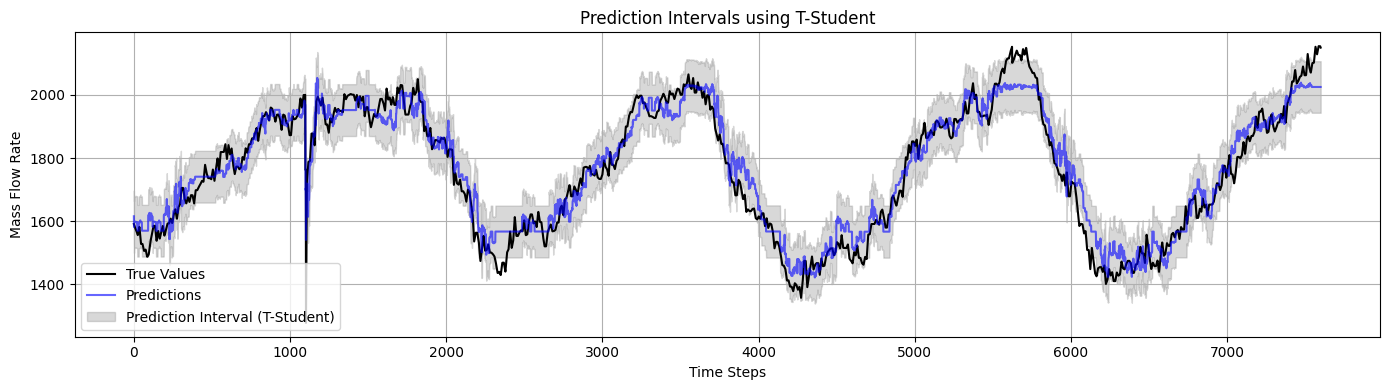

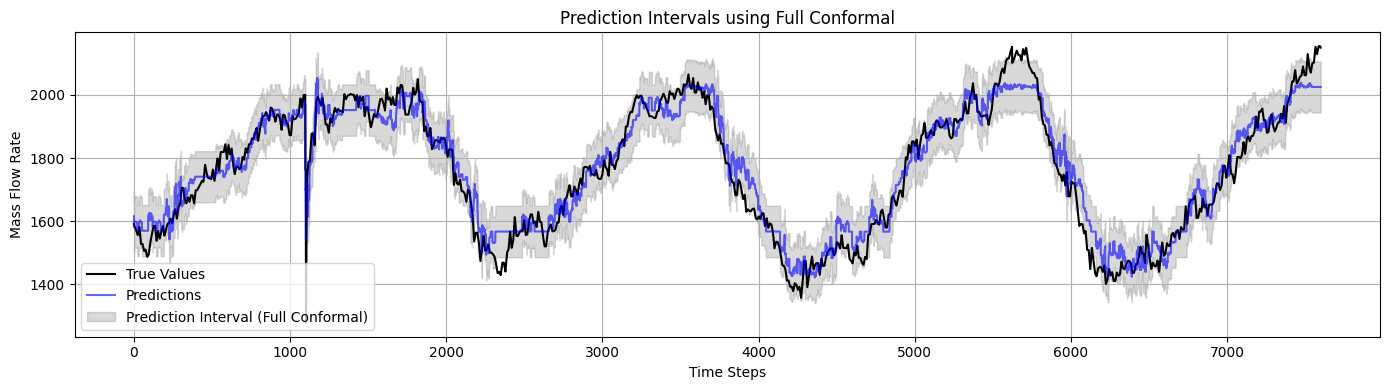

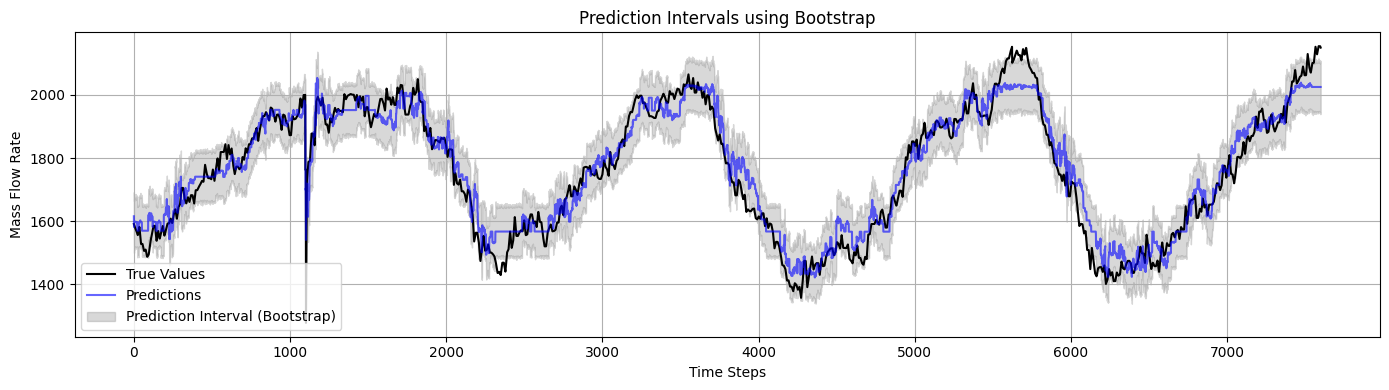

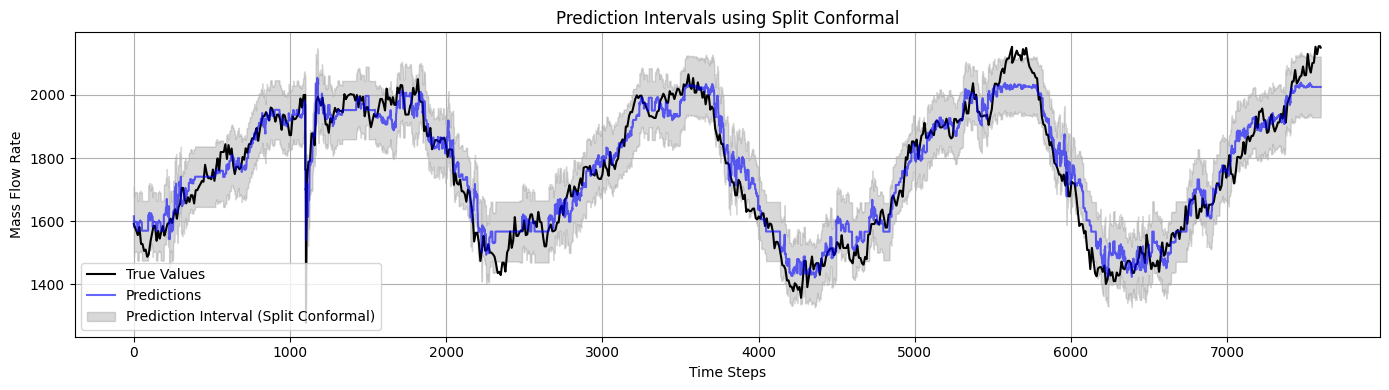

In [13]:
import matplotlib.pyplot as plt

def plot_prediction_intervals(results, method, lower_bound_col, upper_bound_col):
    """
    Função para plotar os intervalos de predição com os valores reais e previstos.
    
    Parâmetros:
    - results: DataFrame contendo os resultados do backtest.
    - method: Nome do método para exibir no título do gráfico.
    - lower_bound_col: Nome da coluna com os limites inferiores.
    - upper_bound_col: Nome da coluna com os limites superiores.
    """
    plt.figure(figsize=(14, 4))
    
    # Plotar os valores reais
    plt.plot(results['y_true'], label='True Values', color='black')
    
    # Plotar as predições do modelo
    plt.plot(results['y_pred'], label='Predictions', color='blue', alpha=0.6)
    
    # Plotar os intervalos de predição
    plt.fill_between(
        range(len(results)),
        results[lower_bound_col],
        results[upper_bound_col],
        color='gray',
        alpha=0.3,
        label=f'Prediction Interval ({method})'
    )
    
    plt.title(f'Prediction Intervals using {method}')
    plt.xlabel('Time Steps')
    plt.ylabel('Mass Flow Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot para os quatro métodos
plot_prediction_intervals(results, 'T-Student', 'lower_bound_tstudent', 'upper_bound_tstudent')
plot_prediction_intervals(results, 'Full Conformal', 'lower_bound_full', 'upper_bound_full')
plot_prediction_intervals(results, 'Bootstrap', 'lower_bound_bootstrap', 'upper_bound_bootstrap')
plot_prediction_intervals(results, 'Split Conformal', 'lower_bound_split', 'upper_bound_split')


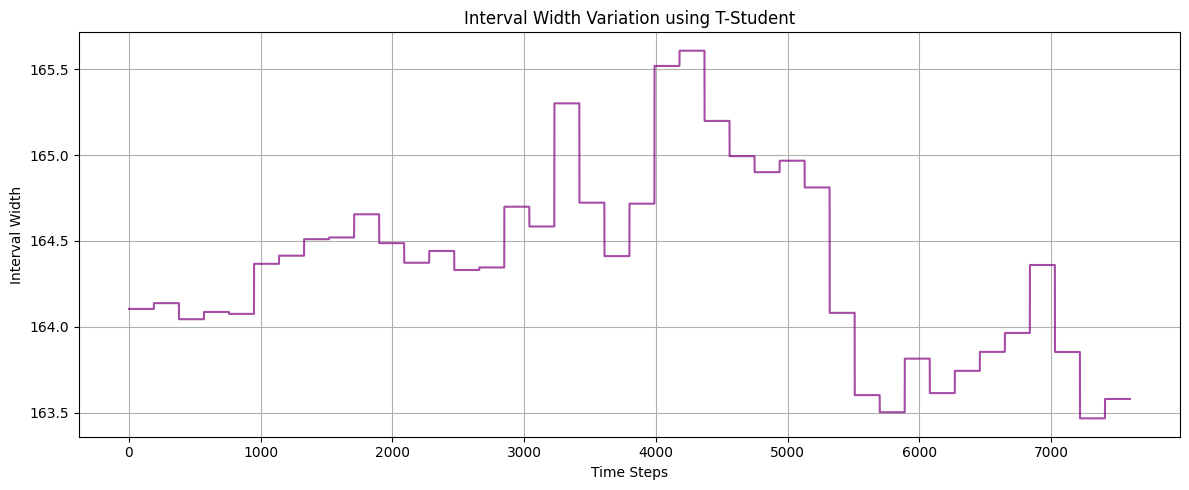

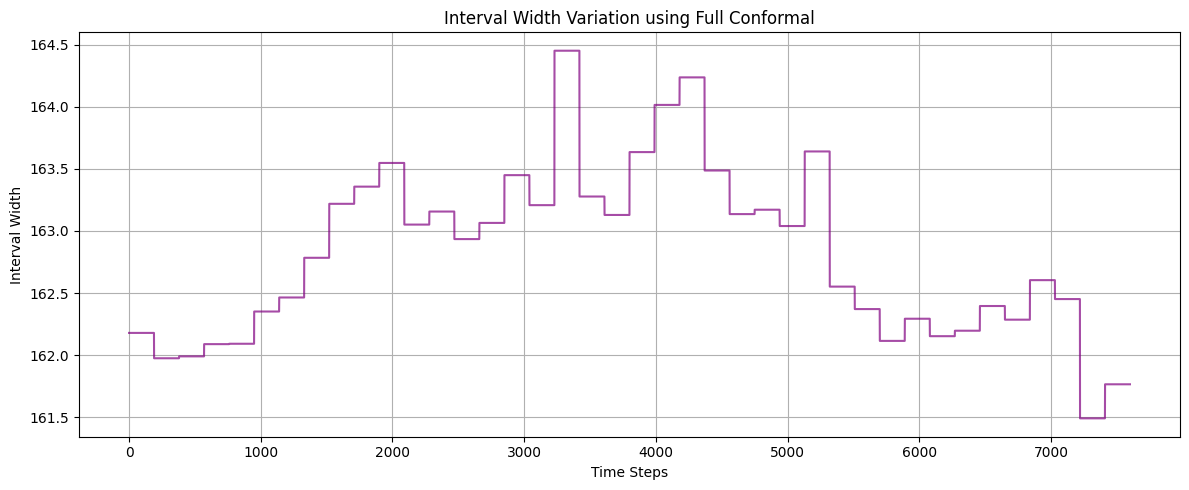

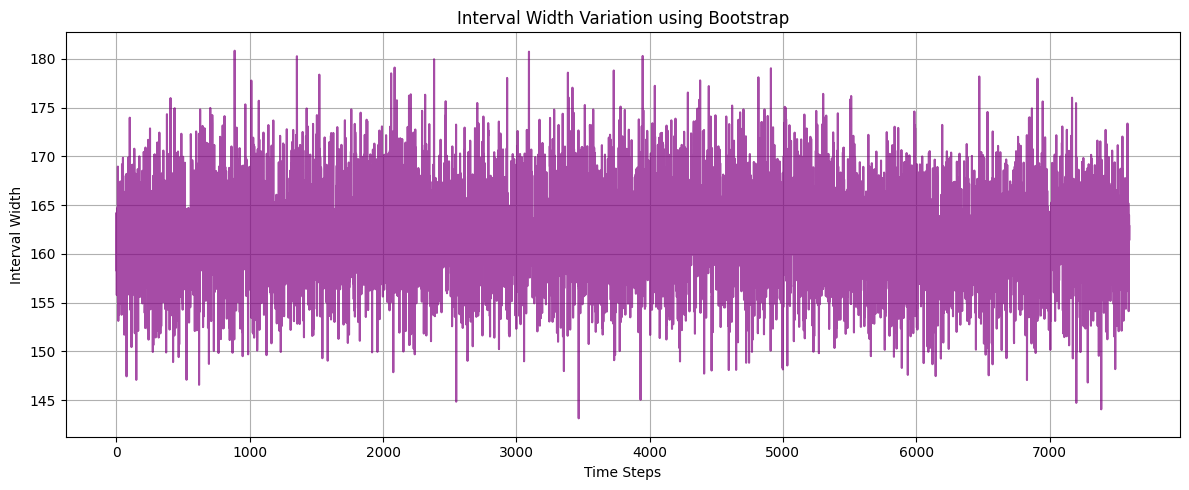

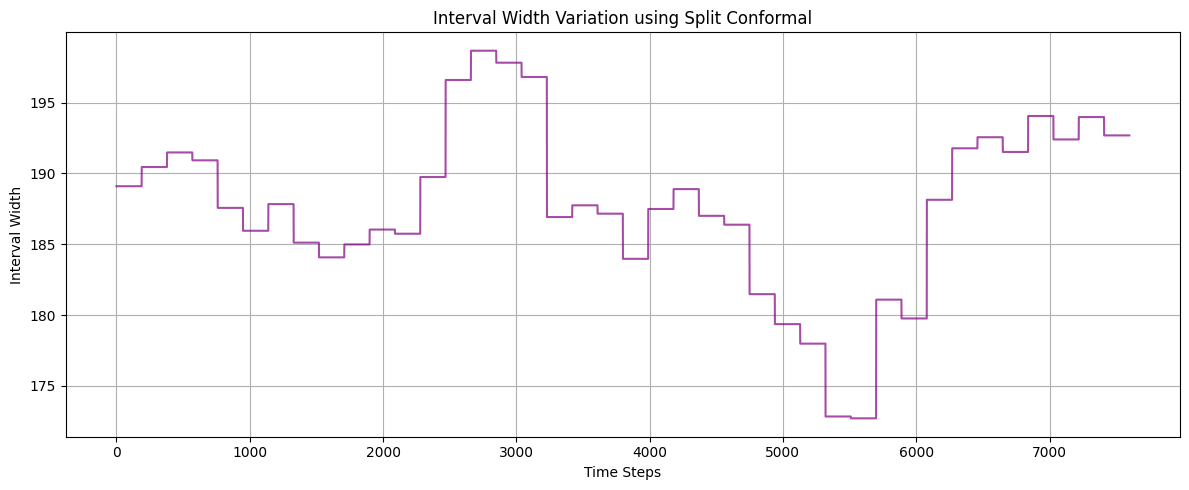

In [14]:
import matplotlib.pyplot as plt

def plot_interval_width(results, method, width_col):
    """
    Função para plotar a variação do tamanho dos intervalos ao longo do tempo.
    
    Parâmetros:
    - results: DataFrame contendo os resultados do backtest.
    - method: Nome do método para exibir no título do gráfico.
    - width_col: Nome da coluna com os tamanhos dos intervalos.
    """
    plt.figure(figsize=(12, 5))
    plt.plot(results[width_col], color='purple', alpha=0.7)
    plt.title(f'Interval Width Variation using {method}')
    plt.xlabel('Time Steps')
    plt.ylabel('Interval Width')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot para os quatro métodos
plot_interval_width(results, 'T-Student', 'width_tstudent')
plot_interval_width(results, 'Full Conformal', 'width_full')
plot_interval_width(results, 'Bootstrap', 'width_bootstrap')
plot_interval_width(results, 'Split Conformal', 'width_split')


In [ ]:
!pip install nbformat

In [33]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'browser'
def plot_prediction_intervals(results, method, color):
    fig = go.Figure()

    # Plotar os valores reais
    fig.add_trace(go.Scatter(
        x=list(range(len(results))),
        y=results['y_true'],
        mode='lines',
        name='True Values',
        line=dict(color='black')
    ))

    # Plotar os valores preditos
    fig.add_trace(go.Scatter(
        x=list(range(len(results))),
        y=results['y_pred'],
        mode='lines',
        name='Predictions',
        line=dict(color=color)
    ))

    # Plotar os limites superiores dos intervalos de predição
    fig.add_trace(go.Scatter(
        x=list(range(len(results))),
        y=results[f'upper_bound_{method}'],
        mode='lines',
        name=f'Upper Bound ({method})',
        line=dict(color=color, dash='dot'),
        opacity=0.5
    ))

    # Plotar os limites inferiores dos intervalos de predição
    fig.add_trace(go.Scatter(
        x=list(range(len(results))),
        y=results[f'lower_bound_{method}'],
        mode='lines',
        name=f'Lower Bound ({method})',
        line=dict(color=color, dash='dot'),
        fill='tonexty',
        fillcolor='rgba(0, 0, 255, 0.1)',  # Cor de preenchimento entre os intervalos
        opacity=0.5
    ))

    # Configurações do layout
    fig.update_layout(
        title=f'Prediction Intervals using {method}',
        xaxis_title='Time Steps',
        yaxis_title='Mass Flow Rate',
        template='plotly_white',
        legend=dict(x=0, y=1),
        hovermode='x unified'
    )

    # Exibir o gráfico interativo
    fig.show()

# Exemplo de uso:
plot_prediction_intervals(results, method='bootstrap', color='blue')
plot_prediction_intervals(results, method='tstudent', color='green')
plot_prediction_intervals(results, method='full', color='red')
plot_prediction_intervals(results, method='split', color='purple')



In [15]:
# Não precisamos mais normalizar os dados
'''
# Definir os valores mínimos e máximos originais (obtidos do conjunto de dados original)
y_min = dt['bal75'].min()
y_max = dt['bal75'].max()

# Revertendo a normalização para cada coluna de interesse
results['y_true'] = results['y_true'] * (y_max - y_min) + y_min
results['y_pred'] = results['y_pred'] * (y_max - y_min) + y_min
results['lower_bound_tstudent'] = results['lower_bound_tstudent'] * (y_max - y_min) + y_min
results['upper_bound_tstudent'] = results['upper_bound_tstudent'] * (y_max - y_min) + y_min
results['lower_bound_full'] = results['lower_bound_full'] * (y_max - y_min) + y_min
results['upper_bound_full'] = results['upper_bound_full'] * (y_max - y_min) + y_min
results['lower_bound_bootstrap'] = results['lower_bound_bootstrap'] * (y_max - y_min) + y_min
results['upper_bound_bootstrap'] = results['upper_bound_bootstrap'] * (y_max - y_min) + y_min
results['lower_bound_split'] = results['lower_bound_split'] * (y_max - y_min) + y_min
results['upper_bound_split'] = results['upper_bound_split'] * (y_max - y_min) + y_min

# Reverter a escala das larguras dos intervalos (opcional)
results['width_tstudent'] = results['width_tstudent'] * (y_max - y_min)
results['width_full'] = results['width_full'] * (y_max - y_min)
results['width_bootstrap'] = results['width_bootstrap'] * (y_max - y_min)
results['width_split'] = results['width_split'] * (y_max - y_min)

# Salvando o DataFrame revertido em um arquivo CSV
results.to_csv('backtest01_prediction_intervals_reverted.csv', index=False)

# Visualizar os resultados revertidos
print(results.head())

'''

"\n# Definir os valores mínimos e máximos originais (obtidos do conjunto de dados original)\ny_min = dt['bal75'].min()\ny_max = dt['bal75'].max()\n\n# Revertendo a normalização para cada coluna de interesse\nresults['y_true'] = results['y_true'] * (y_max - y_min) + y_min\nresults['y_pred'] = results['y_pred'] * (y_max - y_min) + y_min\nresults['lower_bound_tstudent'] = results['lower_bound_tstudent'] * (y_max - y_min) + y_min\nresults['upper_bound_tstudent'] = results['upper_bound_tstudent'] * (y_max - y_min) + y_min\nresults['lower_bound_full'] = results['lower_bound_full'] * (y_max - y_min) + y_min\nresults['upper_bound_full'] = results['upper_bound_full'] * (y_max - y_min) + y_min\nresults['lower_bound_bootstrap'] = results['lower_bound_bootstrap'] * (y_max - y_min) + y_min\nresults['upper_bound_bootstrap'] = results['upper_bound_bootstrap'] * (y_max - y_min) + y_min\nresults['lower_bound_split'] = results['lower_bound_split'] * (y_max - y_min) + y_min\nresults['upper_bound_split'] 

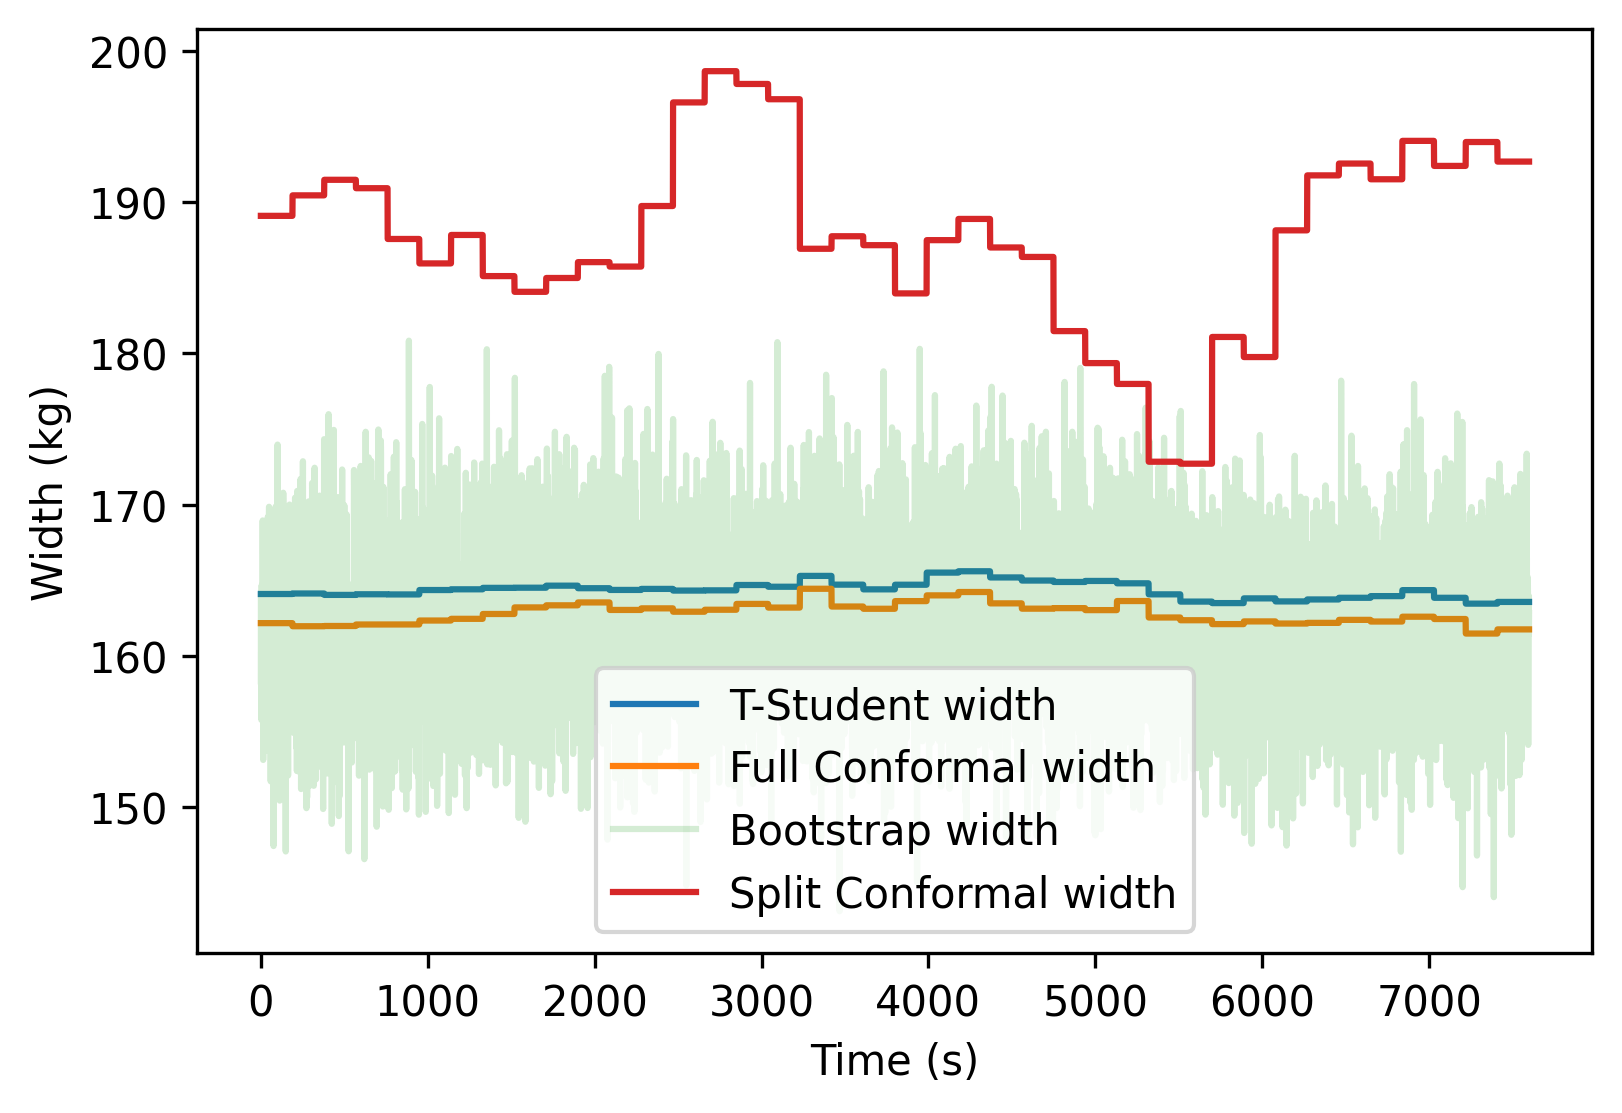

In [34]:
import matplotlib.pyplot as plt

# Plotando as diferenças entre os limites superiores e inferiores de cada método
plt.figure(figsize=(6, 4), dpi=300)

# Plot de cada coluna de diferença
plt.plot(results.index, results['width_tstudent'], label='T-Student width')
plt.plot(results.index, results['width_full'], label='Full Conformal width')
plt.plot(results.index, results['width_bootstrap'], label='Bootstrap width', alpha=0.2)
plt.plot(results.index, results['width_split'], label='Split Conformal width')

# Personalização do gráfico
plt.xlabel('Time (s)')
plt.ylabel('Width (kg)')
#plt.title('Variation of Gap Width Over Time for Each Method w = 190.')
plt.legend()
plt.grid(False)
plt.show()

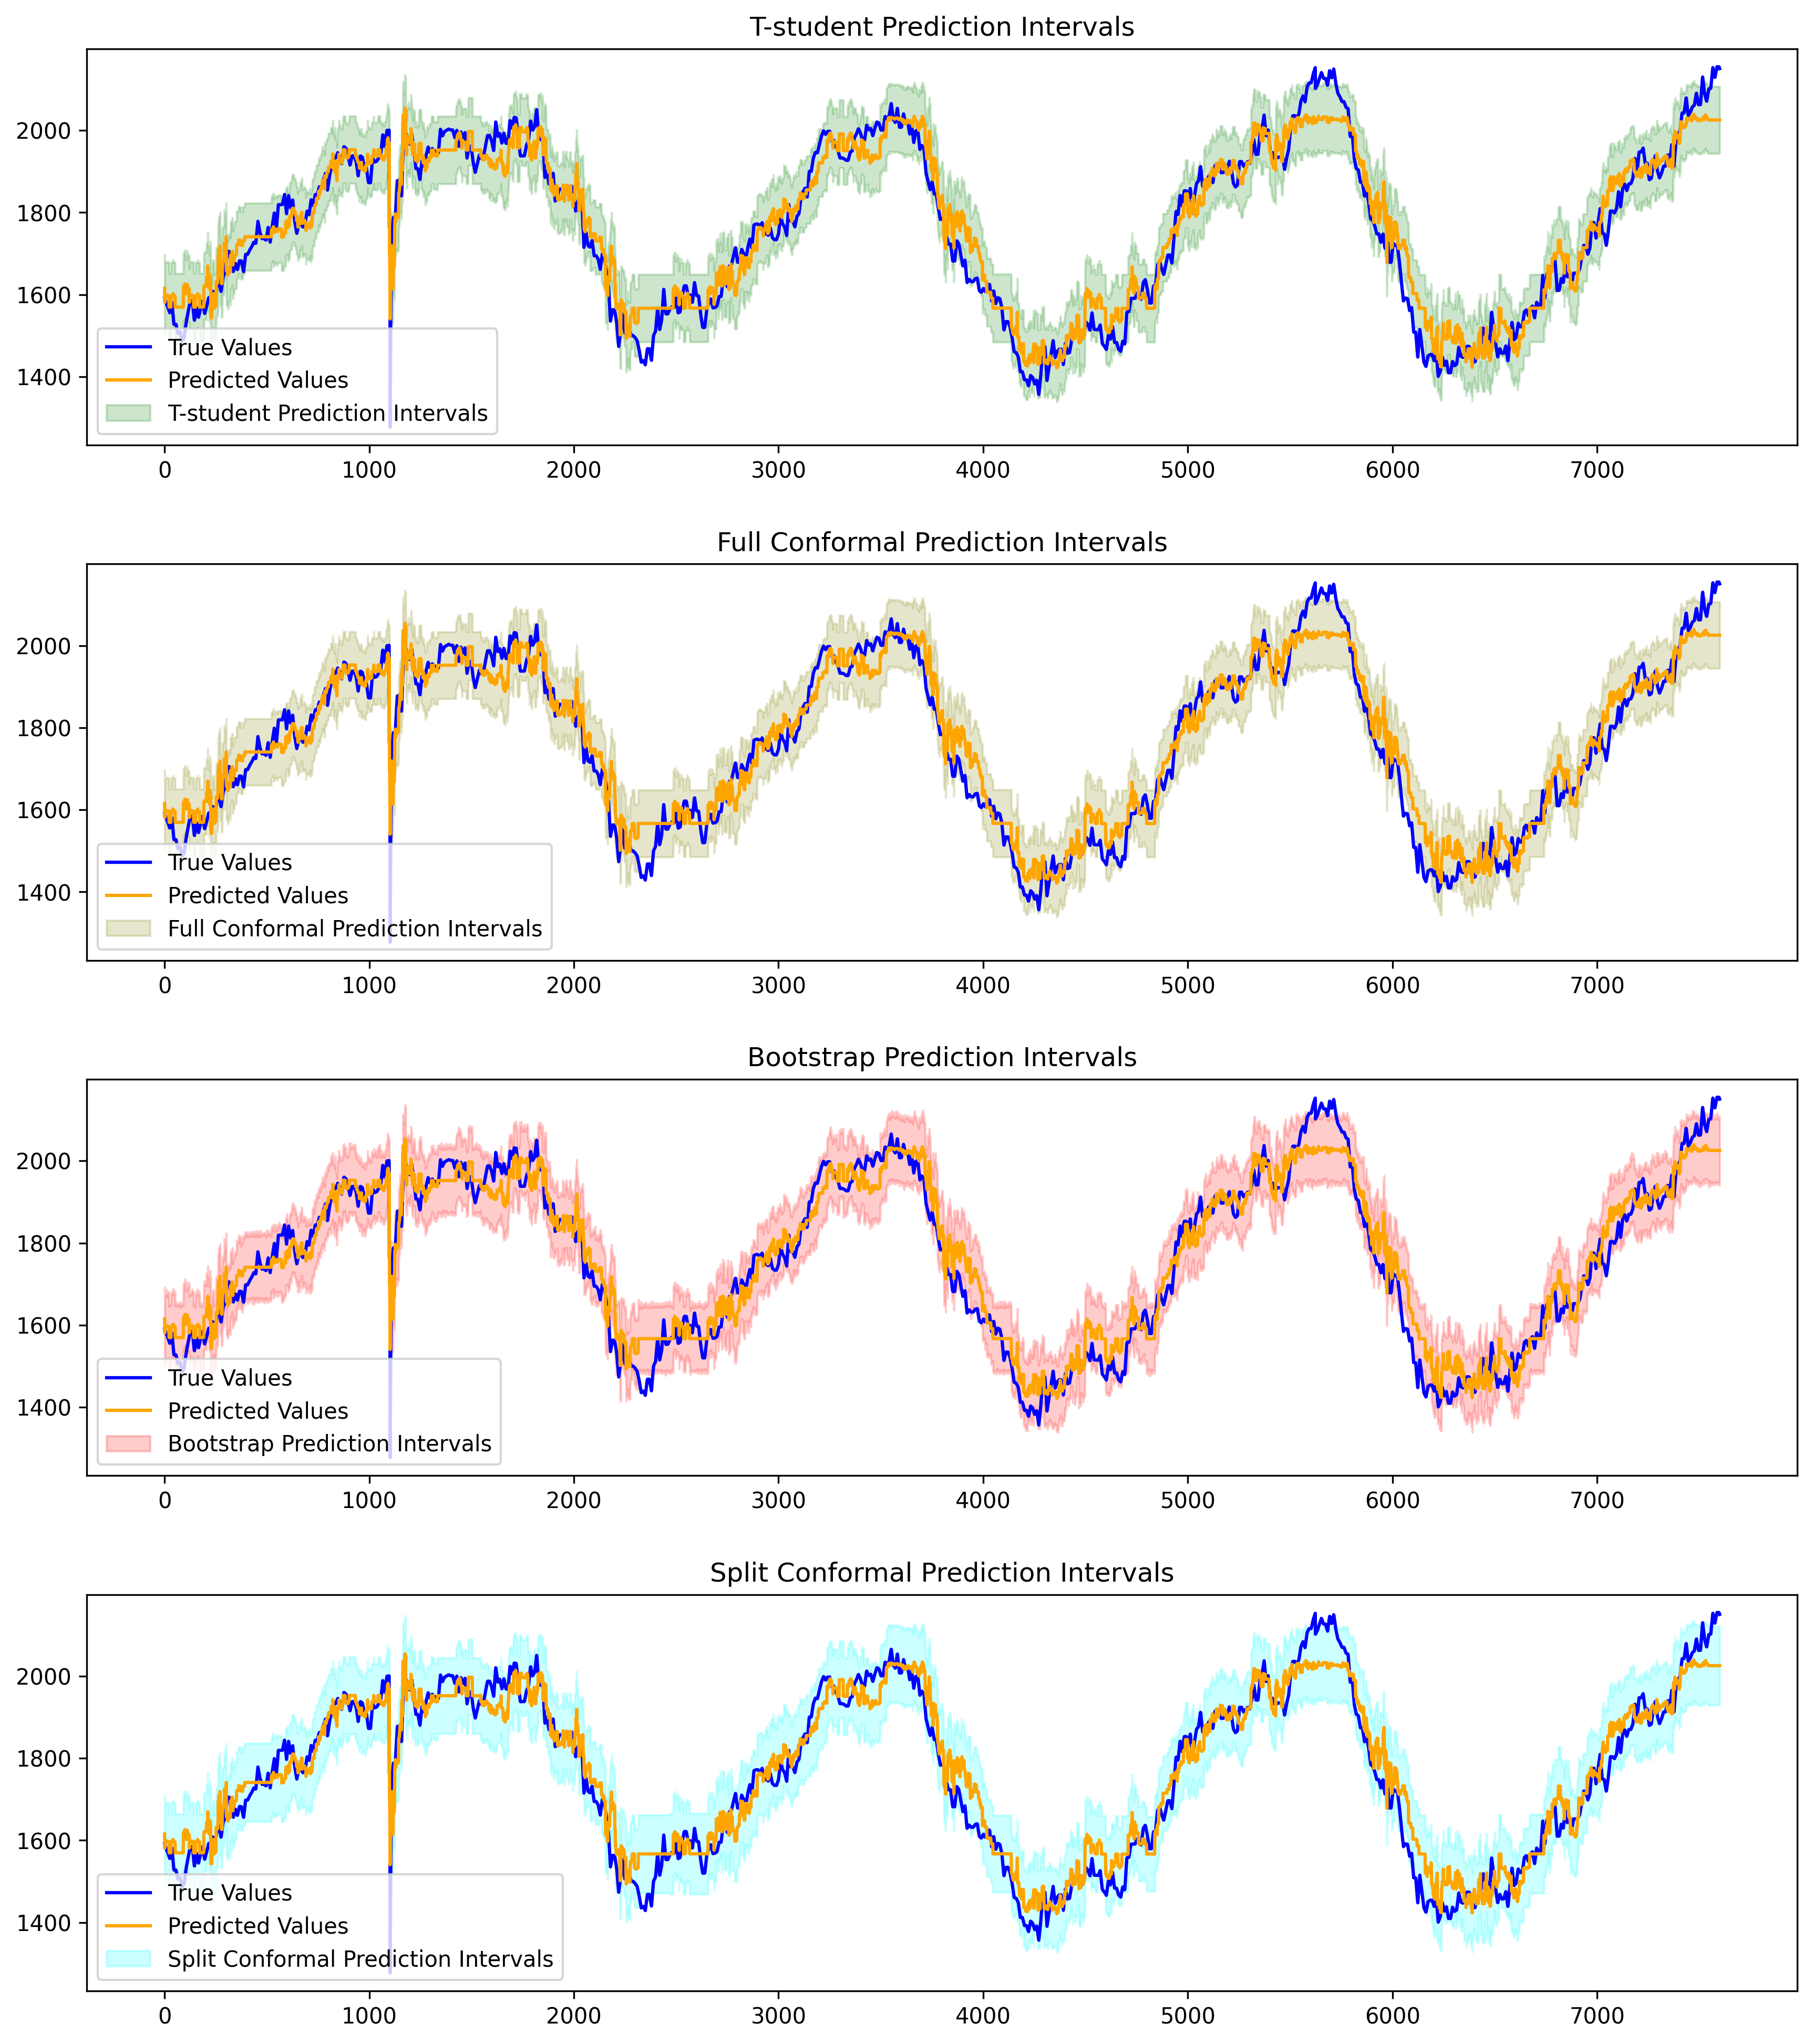

In [35]:
# Definir o índice como uma sequência numérica
results.index = np.arange(len(results))

# Configuração dos subplots
fig, axs = plt.subplots(4, 1, figsize=(14, 16), dpi=300)


# Gráfico 1: T-student Prediction Intervals
axs[0].plot(results['y_true'], label='True Values', color='blue')
axs[0].plot(results['y_pred'], label='Predicted Values', color='orange')
axs[0].fill_between(results.index, results['lower_bound_tstudent'], results['upper_bound_tstudent'], color='green', alpha=0.2, label='T-student Prediction Intervals')
axs[0].set_title('T-student Prediction Intervals')
axs[0].legend()

# Gráfico 2: Full Conformal Intervals
axs[1].plot(results['y_true'], label='True Values', color='blue')
axs[1].plot(results['y_pred'], label='Predicted Values', color='orange')
axs[1].fill_between(results.index, results['lower_bound_full'], results['upper_bound_full'], color='olive', alpha=0.2, label='Full Conformal Prediction Intervals')
axs[1].set_title('Full Conformal Prediction Intervals')
axs[1].legend()

# Gráfico 3: Bootstrap Prediction Intervals
axs[2].plot(results['y_true'], label='True Values', color='blue')
axs[2].plot(results['y_pred'], label='Predicted Values', color='orange')
axs[2].fill_between(results.index, results['lower_bound_bootstrap'], results['upper_bound_bootstrap'], color='red', alpha=0.2, label='Bootstrap Prediction Intervals')
axs[2].set_title('Bootstrap Prediction Intervals')
axs[2].legend()

# Gráfico 4: Split Conformal Prediction Intervals
axs[3].plot(results['y_true'], label='True Values', color='blue')
axs[3].plot(results['y_pred'], label='Predicted Values', color='orange')
axs[3].fill_between(results.index, results['lower_bound_split'], results['upper_bound_split'], color='cyan', alpha=0.2, label='Split Conformal Prediction Intervals')
axs[3].set_title('Split Conformal Prediction Intervals')
axs[3].legend()

# Melhorar o espaçamento dos subplots
# Melhorar o espaçamento dos subplots
plt.subplots_adjust(hspace=0.3)  # Ajuste o valor de hspace para o espaçamento desejado

# Exibir o gráfico
plt.show()

In [36]:
# Importar as bibliotecas necessárias
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Parâmetros para CWC
eta = 10  # Parâmetro de ajuste para penalização da cobertura
alpha = 0.05  # Nível de significância

# Função para calcular o CWC
def calculate_cwc(coverage, mean_width, alpha=0.05, eta=10):
    gamma = 1 if coverage < (1 - alpha) else 0
    cwc = mean_width * (1 + gamma * np.exp(-eta * (coverage - (1 - alpha))))
    return cwc

# Função para calcular métricas de conformal prediction para um intervalo de predição específico
def calculate_mapie_metrics(y_true, y_pred, lower_bound, upper_bound, alpha=0.05):
    # Calcular a cobertura: quantas vezes o valor real está dentro do intervalo de predição
    coverage = regression_coverage_score(y_true, lower_bound, upper_bound)

    # Calcular a largura média do intervalo
    mean_width = regression_mean_width_score(lower_bound, upper_bound)

    # Calcular o CWC (Coverage Width-based Criterion)
    cwc = calculate_cwc(coverage, mean_width, alpha=alpha, eta=eta)

    # Calcular o RMSE entre os valores preditos e reais
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calcular o R² entre os valores preditos e reais
    r2 = r2_score(y_true, y_pred)

    # Calcular o MAE entre os valores preditos e reais
    mae = mean_absolute_error(y_true, y_pred)

    # Retornar as métricas calculadas
    return coverage, mean_width, cwc, rmse, r2, mae

# Dicionário para armazenar os resultados das métricas para cada método
metrics_results = {}

# Supondo que 'results' seja o DataFrame contendo os valores revertidos
methods = {
    'T-Student': ('lower_bound_tstudent', 'upper_bound_tstudent'),
    'Full Conformal': ('lower_bound_full', 'upper_bound_full'),
    'Bootstrap': ('lower_bound_bootstrap', 'upper_bound_bootstrap'),
    'Split Conformal': ('lower_bound_split', 'upper_bound_split')
}

# Calcular as métricas para cada método
for method, (lower_col, upper_col) in methods.items():
    coverage, mean_width, cwc, rmse, r2, mae = calculate_mapie_metrics(
        results['y_true'].values,
        results['y_pred'].values,
        results[lower_col].values,
        results[upper_col].values
    )
    metrics_results[method] = {
        'Coverage': coverage,
        'Mean Width': mean_width,
        'CWC': cwc,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae
    }

# Convertendo os resultados para um DataFrame para facilitar a visualização
df_metrics = pd.DataFrame(metrics_results).T
print(df_metrics)


                 Coverage  Mean Width         CWC       RMSE        R²  \
T-Student        0.891711  164.369363  458.790401  50.913047  0.936115   
Full Conformal   0.888158  162.819870  465.012768  50.913047  0.936115   
Bootstrap        0.888289  162.047436  462.411225  50.913047  0.936115   
Split Conformal  0.929342  187.667498  418.398081  50.913047  0.936115   

                       MAE  
T-Student        40.674077  
Full Conformal   40.674077  
Bootstrap        40.674077  
Split Conformal  40.674077  


100%|██████████| 40/40 [00:22<00:00,  1.76it/s]


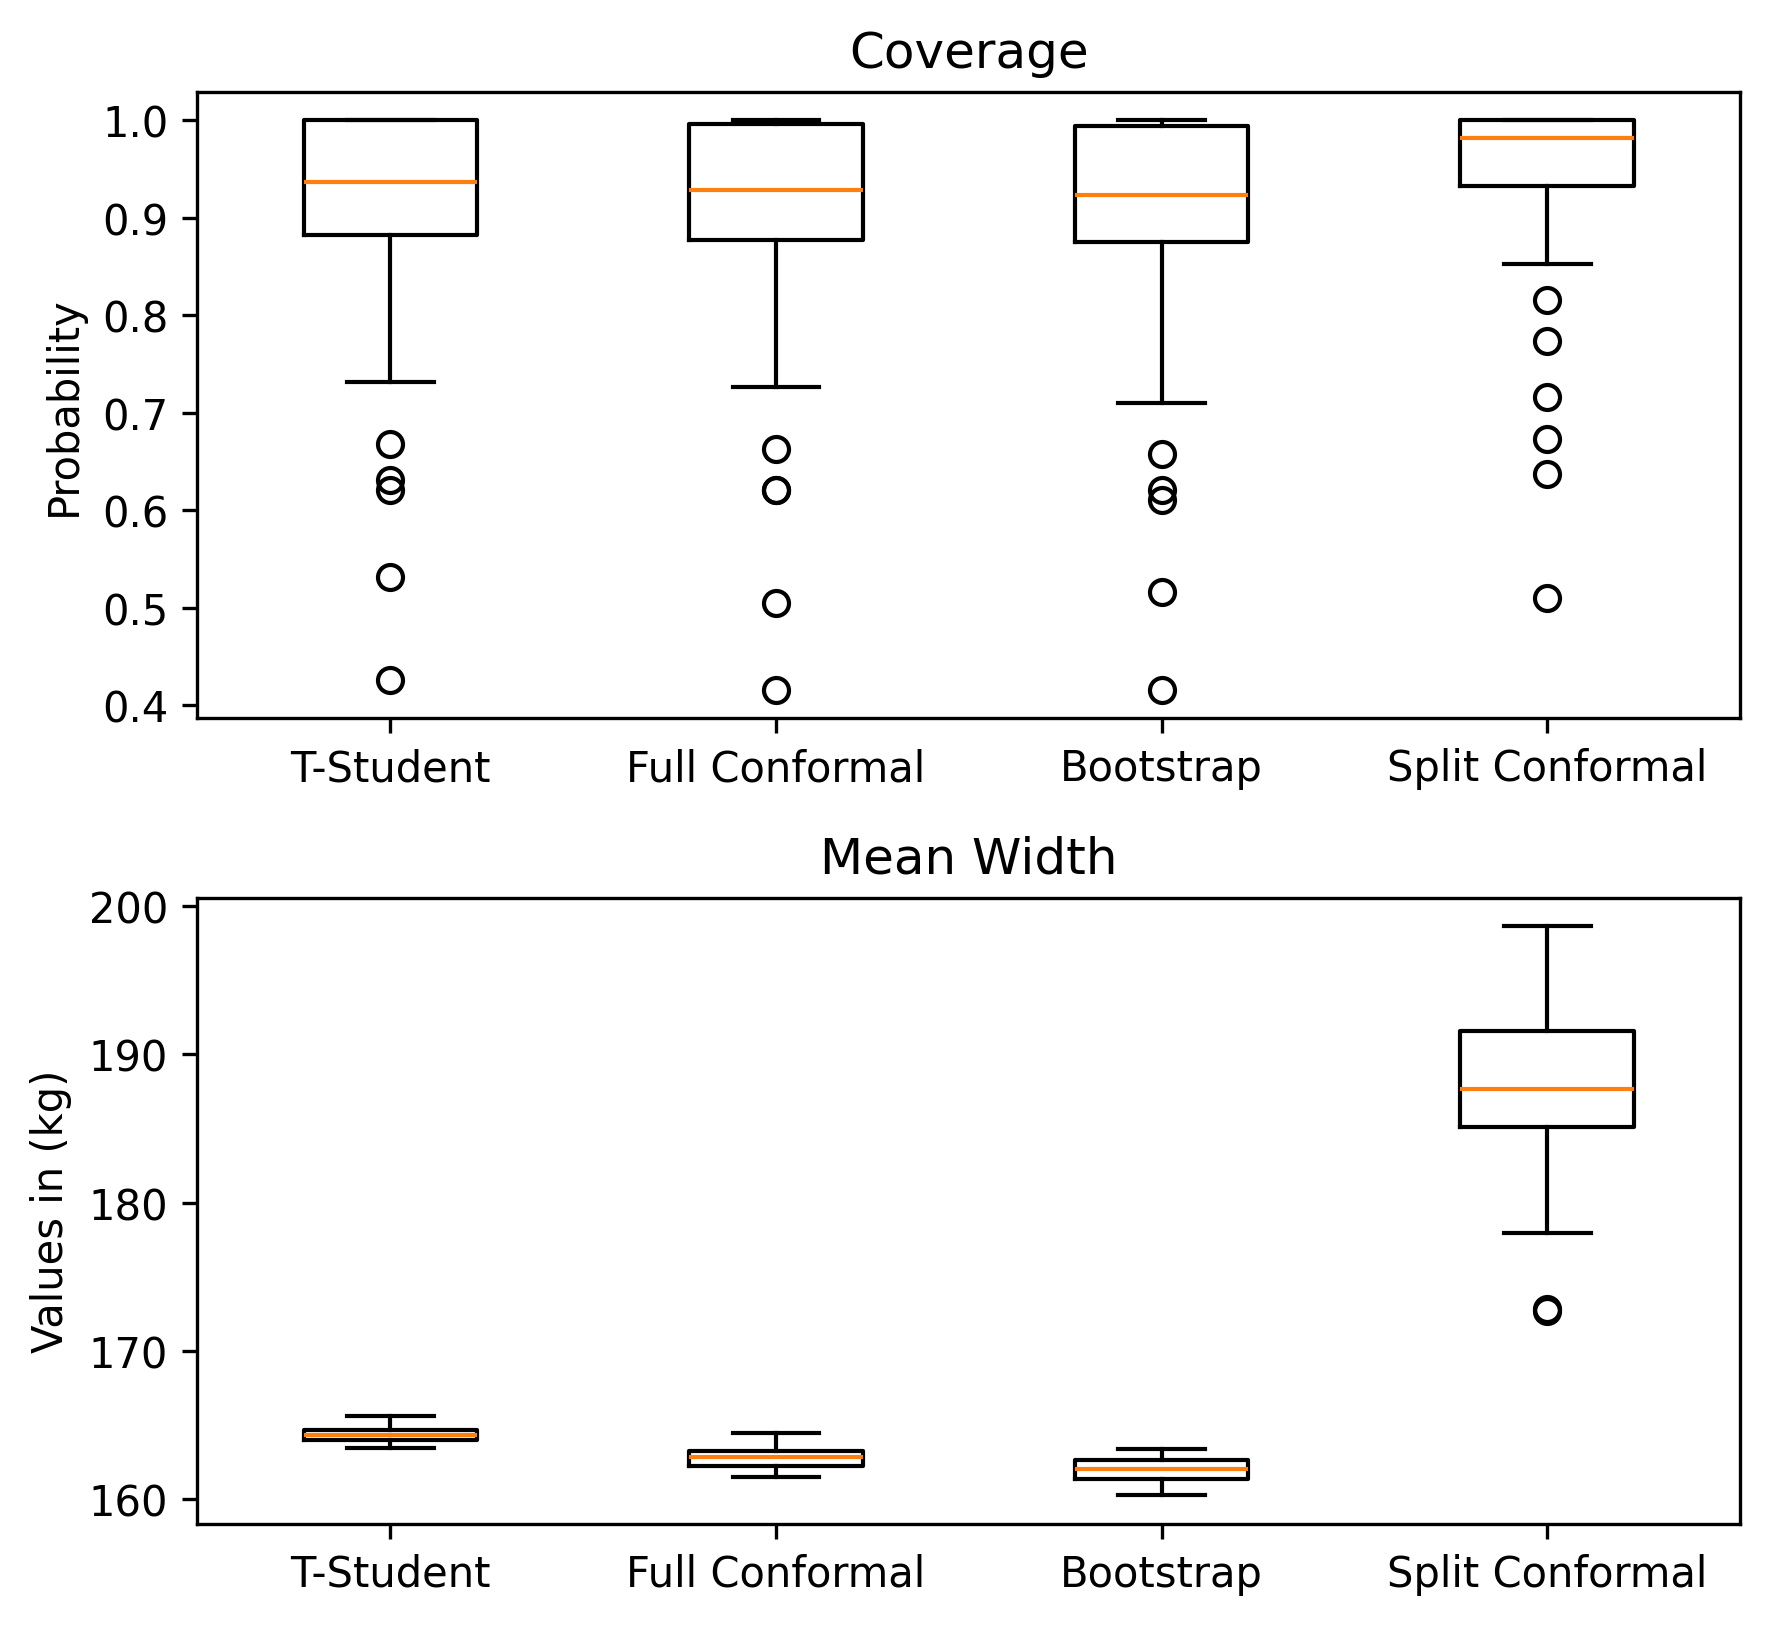

In [37]:
# Versão para calcular 30 iterações respeiando a ordem dos dados com divisão 80-10-10 (treino, calibração e teste)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils import resample
from lightgbm import LGBMRegressor
from scipy import stats
from tqdm import tqdm

# Funções de cálculo de intervalos de predição e métricas de avaliação

def calculate_prediction_intervals(y_pred, residuals, n, p, alpha=0.05):
    s_err = np.std(residuals, ddof=1)  # Erro padrão dos resíduos
    dof = n - p
    t_value = stats.t.ppf(1 - alpha/2, dof)
    margin_of_error = t_value * s_err * np.sqrt(1 + 1/n)
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error
    return lower_bound, upper_bound

# Estimativa Intervalar com Full Conformal Prediction
def full_conformal_prediction_intervals(model, X_train, X_test, y_train, alpha=0.05):
    """
    Função para calcular intervalos de predição usando Full Conformal Prediction,
    implementando a fórmula correta para o cálculo do quantil.

    Parâmetros:
    - model: O modelo a ser treinado.
    - X_train: Conjunto de treinamento (features).
    - X_test: Conjunto de teste (features).
    - y_train: Valores alvo do conjunto de treinamento.
    - alpha: Nível de significância (0.05 para intervalo de confiança de 95%).

    Retorna:
    - lower_bound: Limite inferior dos intervalos de predição para o conjunto de teste.
    - upper_bound: Limite superior dos intervalos de predição para o conjunto de teste.
    - quantile: O quantil usado para os cálculos.
    """
    # Treinar o modelo no conjunto de treino
    model.fit(X_train, y_train)

    # Fazer predições no conjunto de treino
    y_pred_train = model.predict(X_train)

    # Calcular os resíduos (erros absolutos) no conjunto de treino
    residuals_train = np.abs(y_train - y_pred_train)

    # Calcular o quantil correto com base em ((n + 1) * (1 - alpha))/n
    n = len(X_train)
    q_quantile = (n + 1) * (1 - alpha) / n  # Fórmula correta para o quantil

    # Calcular o quantil dos resíduos de treino
    quantile = np.quantile(residuals_train, q_quantile)

    # Fazer predições no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os intervalos de predição para o conjunto de teste
    lower_bound = y_pred_test - quantile
    upper_bound = y_pred_test + quantile

    return lower_bound, upper_bound, quantile

# Estimativa Intervalar com Split Conformal Prediction
def split_conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test, alpha=0.05):
    # Treinar o modelo no conjunto de treino
    model.fit(X_train, y_train)
    # Fazer predições para oconujot de calibração
    y_pred_cal = model.predict(X_cal)
    # Calcular os resíduos (erros absolutos) no conjunto de calibração
    y_cal_error = np.abs(y_cal - y_pred_cal)
    # Calcular o quantil correto com base em (n_cal + 1) * (1 - alpha) / n_cal
    n_cal = len(y_cal)
    q_quantile = (n_cal + 1) * (1 - alpha) / n_cal
    quantile = np.quantile(y_cal_error, q_quantile)
    # Fazer predições no conjunto de teste
    y_pred_test = model.predict(X_test)
    # Calcular os intervalos de predição para o conjunto de teste
    lower_bound = y_pred_test - quantile
    upper_bound = y_pred_test + quantile

    return lower_bound, upper_bound

# Estimativa Intervalar com Bootstrap
def bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=0.05):
    # Fazer previsões no conjunto de teste
    y_pred_test = model.predict(X_test)

    # Calcular os resíduos com base nas previsões do conjunto de treino
    residuals = y_train - model.predict(X_train)

    # Inicializar a matriz de predições bootstrap
    n_obs = len(X_test)
    bootstrap_predictions = np.zeros((n_bootstrap, n_obs))

    # Gerar as predições bootstrap
    for i in range(n_bootstrap):
        # Amostrar com substituição dos resíduos de treinamento, ajustando o tamanho
        bootstrap_residuals = resample(residuals, n_samples=n_obs, replace=True)

        # Adicionar os resíduos bootstrap às previsões do conjunto de teste
        bootstrap_predictions[i, :] = y_pred_test + bootstrap_residuals

    # Calcular os intervalos percentuais
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)

    return lower_bound, upper_bound


def calculate_interval_metrics(y_true, y_pred, lower_bound, upper_bound, alpha=0.05):
    coverage_score = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    mean_width_score = np.mean(upper_bound - lower_bound)
    eta = 10
    gamma = 0 if coverage_score >= (1 - alpha) else 1
    cwc = mean_width_score * (1 + gamma * np.exp(-eta * (coverage_score - (1 - alpha))))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return coverage_score, mean_width_score, cwc, rmse, r2, mae

# Definir variáveis de entrada e saída (substitua com seu dataset)
#X = data[['mean_10s', 'diff_1s', 'diff_5s', 'diff_10s', 'std_10s', 'std_5s', 'lag_60s', 'lag_30s']]
X = data[['mean_10s', 'diff_1s', 'diff_10s', 'lag_60s', 'lag_30s']]

y = data['bal75_next_1']

# Configuração para o rolling window
train_size = int(len(X) * 0.8)
cal_size = int(len(X) * 0.1)
test_size = 190
alpha = 0.05

# Armazenar os resultados para box-plots
metrics_results = {
    'T-Student': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE': []},
    'Full Conformal': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE': []},
    'Bootstrap': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE': []},
    'Split Conformal': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE': []}
}

# Rolling Window Backtest com 30 iterações
for _ in range(1):
    for i in tqdm(range(train_size + cal_size, len(X) - test_size, test_size)):
        X_train = X.iloc[i - train_size - cal_size : i - cal_size]
        y_train = y.iloc[i - train_size - cal_size : i - cal_size]
        X_cal = X.iloc[i - cal_size : i]
        y_cal = y.iloc[i - cal_size : i]
        X_test = X.iloc[i : i + test_size]
        y_test = y.iloc[i : i + test_size]

        model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)
        #model = LinearRegression()

        
        # Treinamento do modelo
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        residuals = y_train - model.predict(X_train)
        
        # T-Student Prediction Intervals
        lower_bound, upper_bound = calculate_prediction_intervals(y_pred, residuals, len(X_train), X_train.shape[1])
        coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
        metrics_results['T-Student']['Coverage'].append(coverage)
        metrics_results['T-Student']['Mean Width'].append(mean_width)
        metrics_results['T-Student']['CWC'].append(cwc)
        metrics_results['T-Student']['RMSE'].append(rmse)
        metrics_results['T-Student']['R2'].append(r2)
        metrics_results['T-Student']['MAE'].append(mae)

        # Full Conformal Prediction Intervals
        lower_bound, upper_bound, _ = full_conformal_prediction_intervals(model, X_train, X_test, y_train)
        coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
        metrics_results['Full Conformal']['Coverage'].append(coverage)
        metrics_results['Full Conformal']['Mean Width'].append(mean_width)
        metrics_results['Full Conformal']['CWC'].append(cwc)
        metrics_results['Full Conformal']['RMSE'].append(rmse)
        metrics_results['Full Conformal']['R2'].append(r2)
        metrics_results['Full Conformal']['MAE'].append(mae)

        # Bootstrap Prediction Intervals
        lower_bound, upper_bound = bootstrap_prediction_intervals(model, X_train, y_train, X_test)
        coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
        metrics_results['Bootstrap']['Coverage'].append(coverage)
        metrics_results['Bootstrap']['Mean Width'].append(mean_width)
        metrics_results['Bootstrap']['CWC'].append(cwc)
        metrics_results['Bootstrap']['RMSE'].append(rmse)
        metrics_results['Bootstrap']['R2'].append(r2)
        metrics_results['Bootstrap']['MAE'].append(mae)

        # Split Conformal Prediction Intervals
        lower_bound, upper_bound = split_conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test)
        coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred, lower_bound, upper_bound)
        metrics_results['Split Conformal']['Coverage'].append(coverage)
        metrics_results['Split Conformal']['Mean Width'].append(mean_width)
        metrics_results['Split Conformal']['CWC'].append(cwc)
        metrics_results['Split Conformal']['RMSE'].append(rmse)
        metrics_results['Split Conformal']['R2'].append(r2)
        metrics_results['Split Conformal']['MAE'].append(mae)

'''
# Gráficos de Box-Plots para as Métricas de Desempenho do Modelo
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Box-Plots das Métricas de Desempenho do Modelo', fontsize=16)

# Dados para cada métrica de desempenho do modelo
rmse_data = [metrics_results[method]['RMSE'] for method in metrics_results.keys()]
r2_data = [metrics_results[method]['R2'] for method in metrics_results.keys()]
mae_data = [metrics_results[method]['MAE'] for method in metrics_results.keys()]

# Plotando cada métrica de desempenho do modelo
axs[0].boxplot(rmse_data, labels=metrics_results.keys())
axs[0].set_title('RMSE')

axs[1].boxplot(r2_data, labels=metrics_results.keys())
axs[1].set_title('R²')

axs[2].boxplot(mae_data, labels=metrics_results.keys())
axs[2].set_title('MAE')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
'''

import matplotlib.pyplot as plt

# Criar a figura com subplots para Coverage e Mean Width
fig, axs = plt.subplots(2, 1, figsize=(6, 6), dpi=300)  # 2 linhas, 1 coluna
#fig.suptitle('Coverage and Mean Width Score With Rolling Window Size 190', fontsize=16)

# Dados para as métricas Coverage e Mean Width (assumindo que metrics_results é um dicionário conforme descrito)
coverage_data = [metrics_results[method]['Coverage'] for method in metrics_results.keys()]
mean_width_data = [metrics_results[method]['Mean Width'] for method in metrics_results.keys()]
#cwc_data = [metrics_results[method]['CWC'] for method in metrics_results.keys()]

# Plotando Coverage no primeiro subplot
axs[0].boxplot(coverage_data, labels=metrics_results.keys())
axs[0].set_title('Coverage')
axs[0].set_ylabel('Probability')

# Plotando Mean Width no segundo subplot
axs[1].boxplot(mean_width_data, labels=metrics_results.keys())
axs[1].set_title('Mean Width')
axs[1].set_ylabel('Values in (kg)')
'''
# Plotando CWC no terceiro subplot
axs[2].boxplot(cwc_data, labels=metrics_results.keys())
axs[2].set_title('CWC')
axs[2].set_ylabel('Value')
'''
# Ajuste de layout para evitar sobreposição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [20]:
'''
# Para salvar os métricas geradas em um dataframe 
import pandas as pd


# Converter o dicionário para um DataFrame
metrics_df = pd.DataFrame(metrics_results)

# Salvar o DataFrame em um arquivo CSV no diretório atual
metrics_df.to_csv('metrics_results_03_w190.csv', index=False)

print("Resultados salvos em 'metrics_results_03_w190.csv'")

'''

'\n# Para salvar os métricas geradas em um dataframe \nimport pandas as pd\n\n\n# Converter o dicionário para um DataFrame\nmetrics_df = pd.DataFrame(metrics_results)\n\n# Salvar o DataFrame em um arquivo CSV no diretório atual\nmetrics_df.to_csv(\'metrics_results_03_w190.csv\', index=False)\n\nprint("Resultados salvos em \'metrics_results_03_w190.csv\'")\n\n'

In [38]:
# Exportar o modelo para JSON e visualizar a estrutura das árvores
model_structure = model.booster_.dump_model()
print(model_structure['tree_info'][0])  # Visualiza a primeira árvore em formato de dicionário


{'tree_index': 0, 'num_leaves': 31, 'num_cat': 0, 'shrinkage': 1, 'tree_structure': {'split_index': 0, 'split_feature': 0, 'split_gain': 584062016, 'threshold': 22.999980050000005, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': 1765.86, 'internal_weight': 0, 'internal_count': 62273, 'left_child': {'split_index': 2, 'split_feature': 0, 'split_gain': 91674000, 'threshold': 22.000049950000005, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': 1750.19, 'internal_weight': 17204, 'internal_count': 17204, 'left_child': {'split_index': 4, 'split_feature': 3, 'split_gain': 20440700, 'threshold': 21.981800000000003, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': 1743.41, 'internal_weight': 9232, 'internal_count': 9232, 'left_child': {'split_index': 16, 'split_feature': 0, 'split_gain': 2358130, 'threshold': 21.999899950000003, 'decision_type': '<=', 'default_left': True, 'missing_

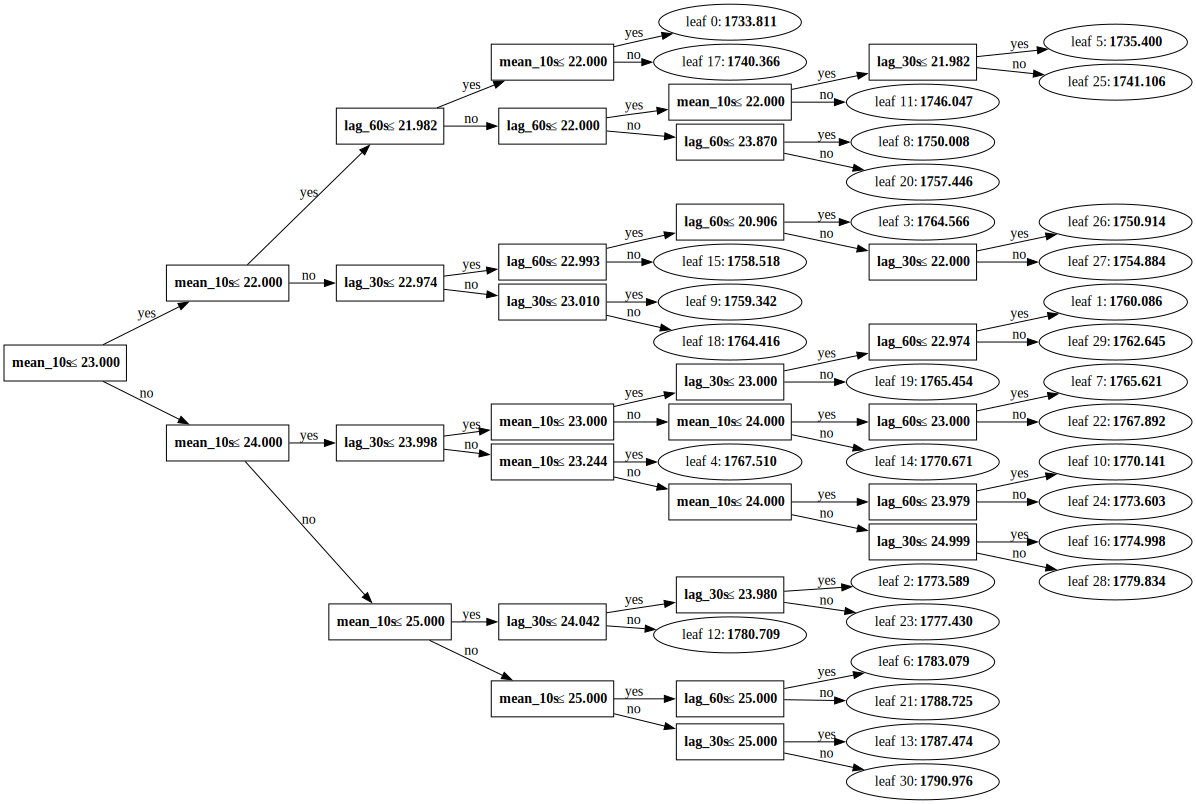

In [39]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import graphviz

# Exportar a primeira árvore para o formato DOT
dot_data = lgb.create_tree_digraph(model, tree_index=0)

# Visualizar a árvore diretamente
graph = graphviz.Source(dot_data.source)
graph


Rolling Window Iterations: 100%|██████████| 30/30 [15:12<00:00, 30.42s/it]


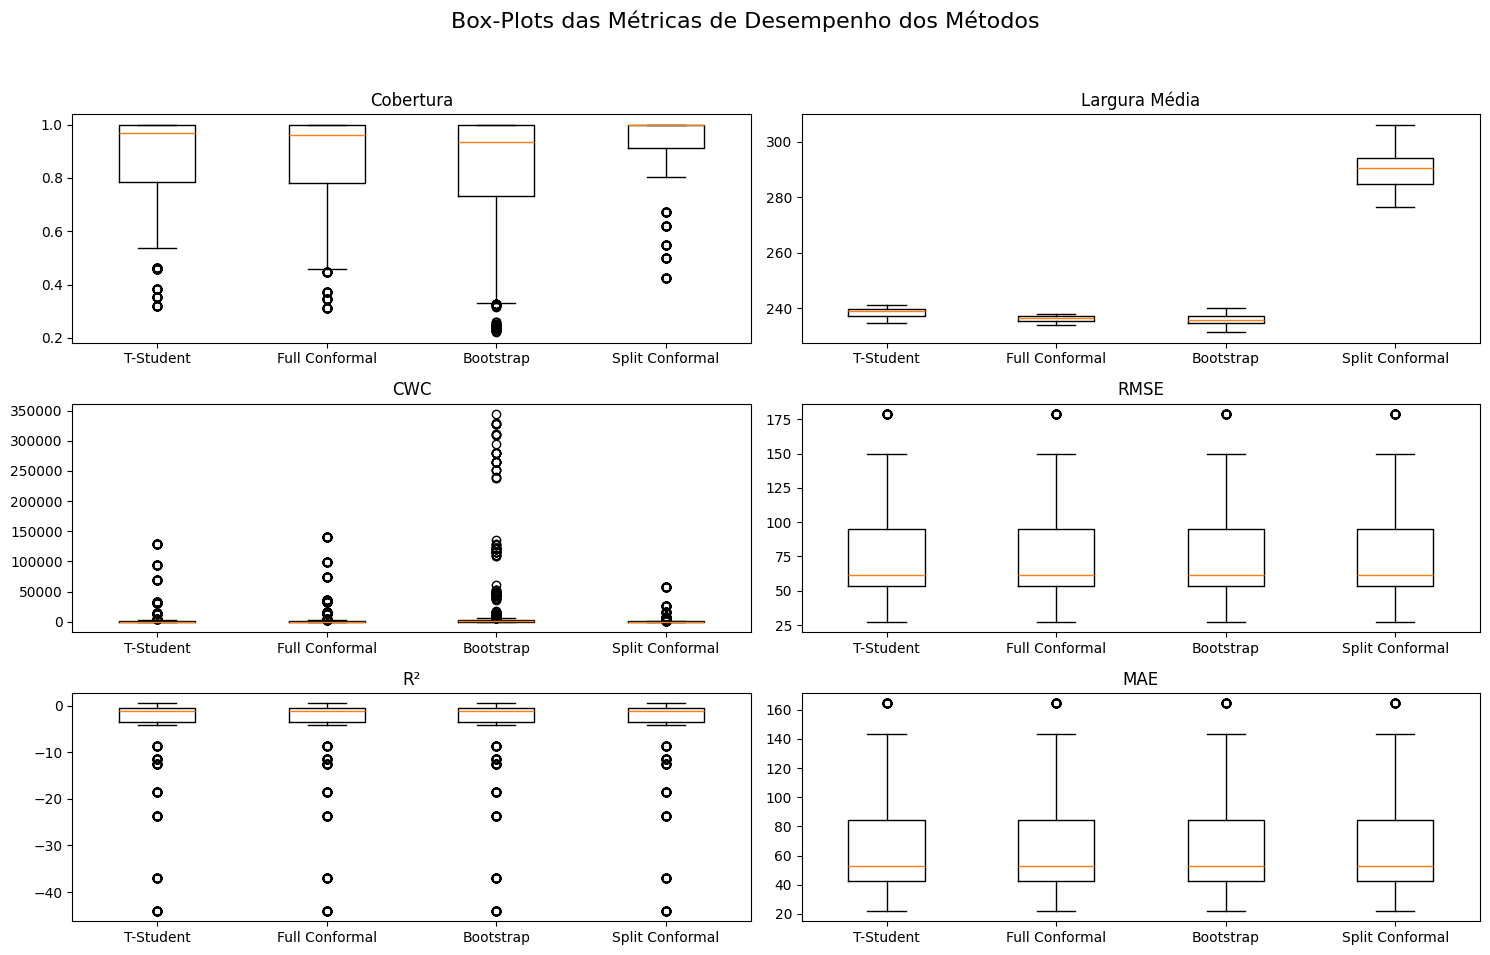

In [23]:
# Versão para calcular 30 iterações usando uma seleção de dados aleatória

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
from scipy import stats
from sklearn.utils import resample
from tqdm import tqdm

# Funções para cálculo de intervalos de predição e métricas
def calculate_prediction_intervals(y_pred, residuals, n, p, alpha=0.05):
    s_err = np.std(residuals, ddof=1)  # Erro padrão dos resíduos
    dof = n - p
    t_value = stats.t.ppf(1 - alpha/2, dof)
    margin_of_error = t_value * s_err * np.sqrt(1 + 1/n)
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error
    return lower_bound, upper_bound

def full_conformal_prediction_intervals(model, X_train, X_test, y_train, alpha=0.05):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    residuals_train = np.abs(y_train - y_pred_train)
    n = len(X_train)
    q_quantile = (n + 1) * (1 - alpha) / n
    quantile = np.quantile(residuals_train, q_quantile)
    y_pred_test = model.predict(X_test)
    lower_bound = y_pred_test - quantile
    upper_bound = y_pred_test + quantile
    return lower_bound, upper_bound

def bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=0.05):
    y_pred_test = model.predict(X_test)
    residuals = y_train - model.predict(X_train)
    n_obs = len(X_test)
    bootstrap_predictions = np.zeros((n_bootstrap, n_obs))
    for i in range(n_bootstrap):
        bootstrap_residuals = resample(residuals, n_samples=n_obs, replace=True)
        bootstrap_predictions[i, :] = y_pred_test + bootstrap_residuals
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)
    return lower_bound, upper_bound

def split_conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test, alpha=0.05):
    model.fit(X_train, y_train)
    y_pred_cal = model.predict(X_cal)
    y_cal_error = np.abs(y_cal - y_pred_cal)
    n_cal = len(y_cal)
    q_quantile = (n_cal + 1) * (1 - alpha) / n_cal
    quantile = np.quantile(y_cal_error, q_quantile)
    y_pred_test = model.predict(X_test)
    lower_bound = y_pred_test - quantile
    upper_bound = y_pred_test + quantile
    return lower_bound, upper_bound

def calculate_interval_metrics(y_true, y_pred, lower_bound, upper_bound, alpha=0.05):
    coverage_score = np.mean((y_true >= lower_bound) & (y_true <= upper_bound))
    mean_width_score = np.mean(upper_bound - lower_bound)
    eta = 10
    gamma = 0 if coverage_score >= (1 - alpha) else 1
    cwc = mean_width_score * (1 + gamma * np.exp(-eta * (coverage_score - (1 - alpha))))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return coverage_score, mean_width_score, cwc, rmse, r2, mae

# Função de Rolling Window com intervalos de predição interativos e janelas aleatórias
def rolling_window_backtest_randomized(X, y, train_size, cal_size, test_size, alpha=0.05, n_iter=30):
    model = LGBMRegressor(num_leaves=31, min_data_in_leaf=20, subsample=0.8, colsample_bytree=0.8, random_state=None, verbose=-1)
    #model = LinearRegression()

    # Inicializar dicionário para armazenar métricas de todas as iterações
    metrics_results = {
        'T-Student': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE': []},
        'Full Conformal': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE': []},
        'Bootstrap': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE': []},
        'Split Conformal': {'Coverage': [], 'Mean Width': [], 'CWC': [], 'RMSE': [], 'R2': [], 'MAE': []}
    }

    for _ in tqdm(range(n_iter), desc="Rolling Window Iterations"):
        y_true, y_pred = [], []
        lower_bounds_tstudent, upper_bounds_tstudent = [], []
        lower_bounds_full, upper_bounds_full = [], []
        lower_bounds_bootstrap, upper_bounds_bootstrap = [], []
        lower_bounds_split, upper_bounds_split = [], []
        
        for i in range(int(train_size + cal_size), len(X) - test_size, test_size):
           
            X_train = X.iloc[i - train_size - cal_size : i - cal_size].sample(frac=1, random_state=None)
            y_train = y.iloc[X_train.index]
            X_cal = X.iloc[i - cal_size : i].sample(frac=1, random_state=None)
            y_cal = y.iloc[X_cal.index]
            X_test = X.iloc[i : i + test_size].sample(frac=1, random_state=None)
            y_test = y.iloc[X_test.index]
            
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)
            residuals = y_train - model.predict(X_train)
            p = X_train.shape[1]

            # T-Student Prediction Intervals
            pred_lower_t, pred_upper_t = calculate_prediction_intervals(y_pred_test, residuals, len(X_train), p, alpha=alpha)
            coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred_test, pred_lower_t, pred_upper_t)
            metrics_results['T-Student']['Coverage'].append(coverage)
            metrics_results['T-Student']['Mean Width'].append(mean_width)
            metrics_results['T-Student']['CWC'].append(cwc)
            metrics_results['T-Student']['RMSE'].append(rmse)
            metrics_results['T-Student']['R2'].append(r2)
            metrics_results['T-Student']['MAE'].append(mae)

            # Full Conformal Prediction Intervals
            full_lower, full_upper = full_conformal_prediction_intervals(model, X_train, X_test, y_train, alpha=alpha)
            coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred_test, full_lower, full_upper)
            metrics_results['Full Conformal']['Coverage'].append(coverage)
            metrics_results['Full Conformal']['Mean Width'].append(mean_width)
            metrics_results['Full Conformal']['CWC'].append(cwc)
            metrics_results['Full Conformal']['RMSE'].append(rmse)
            metrics_results['Full Conformal']['R2'].append(r2)
            metrics_results['Full Conformal']['MAE'].append(mae)

            # Bootstrap Prediction Intervals
            boot_lower, boot_upper = bootstrap_prediction_intervals(model, X_train, y_train, X_test, n_bootstrap=1000, alpha=alpha)
            coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred_test, boot_lower, boot_upper)
            metrics_results['Bootstrap']['Coverage'].append(coverage)
            metrics_results['Bootstrap']['Mean Width'].append(mean_width)
            metrics_results['Bootstrap']['CWC'].append(cwc)
            metrics_results['Bootstrap']['RMSE'].append(rmse)
            metrics_results['Bootstrap']['R2'].append(r2)
            metrics_results['Bootstrap']['MAE'].append(mae)

            # Split Conformal Prediction Intervals
            split_lower, split_upper = split_conformal_prediction_intervals(model, X_train, y_train, X_cal, y_cal, X_test, alpha=alpha)
            coverage, mean_width, cwc, rmse, r2, mae = calculate_interval_metrics(y_test, y_pred_test, split_lower, split_upper)
            metrics_results['Split Conformal']['Coverage'].append(coverage)
            metrics_results['Split Conformal']['Mean Width'].append(mean_width)
            metrics_results['Split Conformal']['CWC'].append(cwc)
            metrics_results['Split Conformal']['RMSE'].append(rmse)
            metrics_results['Split Conformal']['R2'].append(r2)
            metrics_results['Split Conformal']['MAE'].append(mae)

    return metrics_results

# Definir variáveis de entrada
#X = data[['mean_10s', 'diff_1s', 'diff_5s', 'diff_10s', 'std_10s', 'std_5s', 'lag_60s', 'lag_30s']]
X = data[['mean_10s', 'diff_1s', 'diff_10s', 'lag_60s', 'lag_30s']]
y = data['bal75_next_1']
train_size = int(len(X) * 0.8)
cal_size = int(len(X) * 0.1)
test_size = 190
alpha = 0.05
n_iter = 30

# Executar o Rolling Window Backtest com variabilidade
metrics_results = rolling_window_backtest_randomized(X, y, train_size, cal_size, test_size, alpha=alpha, n_iter=n_iter)

# Criar gráficos de box-plot para cada métrica
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Box-Plots das Métricas de Desempenho dos Métodos', fontsize=16)

# Dados para cada métrica
coverage_data = [metrics_results[method]['Coverage'] for method in metrics_results.keys()]
mean_width_data = [metrics_results[method]['Mean Width'] for method in metrics_results.keys()]
cwc_data = [metrics_results[method]['CWC'] for method in metrics_results.keys()]
rmse_data = [metrics_results[method]['RMSE'] for method in metrics_results.keys()]
r2_data = [metrics_results[method]['R2'] for method in metrics_results.keys()]
mae_data = [metrics_results[method]['MAE'] for method in metrics_results.keys()]

# Plotando cada métrica em um subplot
axs[0, 0].boxplot(coverage_data, labels=metrics_results.keys())
axs[0, 0].set_title('Cobertura')

axs[0, 1].boxplot(mean_width_data, labels=metrics_results.keys())
axs[0, 1].set_title('Largura Média')

axs[1, 0].boxplot(cwc_data, labels=metrics_results.keys())
axs[1, 0].set_title('CWC')

axs[1, 1].boxplot(rmse_data, labels=metrics_results.keys())
axs[1, 1].set_title('RMSE')

axs[2, 0].boxplot(r2_data, labels=metrics_results.keys())
axs[2, 0].set_title('R²')

axs[2, 1].boxplot(mae_data, labels=metrics_results.keys())
axs[2, 1].set_title('MAE')

# Ajuste de layout para evitar sobreposição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [24]:
'''
# Salvar os resultados das métricas em um dataframe
import pandas as pd

# Converter o dicionário para um DataFrame
metrics_df = pd.DataFrame(metrics_results)

# Salvar o DataFrame em um arquivo CSV no diretório atual
metrics_df.to_csv('metrics_random190_results.csv', index=False)

print("Resultados salvos em 'metrics_random190_results.csv'")

'''

'\n# Salvar os resultados das métricas em um dataframe\nimport pandas as pd\n\n# Converter o dicionário para um DataFrame\nmetrics_df = pd.DataFrame(metrics_results)\n\n# Salvar o DataFrame em um arquivo CSV no diretório atual\nmetrics_df.to_csv(\'metrics_random190_results.csv\', index=False)\n\nprint("Resultados salvos em \'metrics_random190_results.csv\'")\n\n'